# GEONE - Variogram analysis and kriging for data in 2D with non-stationarity

The goal is to interpolate a non-stationary data set in 2D (based on simple or ordinary kriging) in a domain (grid), where non-stationarity are given as

- local orientation, i.e. map of angle defining the orientation of the main axes of the covariance model
- local factor (multiplier) for the ranges along the main axes of the covariance model
- local factor (multiplier) for the total weight (variance, sill) of the covariance model

One or several of these non-stationary features can be considered.

## Import what is required

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

# import package 'geone'
import geone as gn

In [2]:
# Show version of python and version of geone
import sys 
print(sys.version_info)
print('geone version: ' + gn.__version__)

sys.version_info(major=3, minor=13, micro=7, releaselevel='final', serial=0)
geone version: 1.3.0


## I. Build non-stationary features on a grid
Here are built the following non-stationary features on a grid:

- `alpha_loc`: local varying map of orientation (angle `alpha` = "minus mathematical angle in degrees") ), determining the orientation of the structures
- `r_factor_loc`: local factor (multiplier) for the ranges along the main axes of the covariance model
- `w_factor_loc`: local factor (multiplier) for the total weight (variance, sill) of the covariance model

### Defining domain of simulation (grid)

In [3]:
nx, ny = 301, 161  # number of cells
sx, sy = 1.0, 1.0  # cell unit
ox, oy = -150.5, -80.5  # origin

xmin, xmax = ox, ox+nx*sx
ymin, ymax = oy, oy+ny*sy

# # Set an image with simulation grid geometry defined above, and no variable
# im = gn.img.Img(nx, ny, 1, sx, sy, 1., ox, oy, 0., nv=0)


### Defining non-stationary orientation
The angle `alpha` (= "minus mathematical angle in degrees") locally varying in the grid is defined as 

- `im_alpha`: an image (with one variable on the grid)
- `alpha_loc_func`: a function as a location (in the grid) (interpolating the values in the image, function built from image `im_alpha`)

### How defining the orientation map (`im_alpha`)
The orientation map can be defined as follows:

1. Define a data set consisting in some points in the simulation area with angle (alpha) values attached
2. Krige the data set of alpha over the image grid

**Notes for point 1.**

When matplotlib is used with an interactive backend, the step 1. above can be done by interactively drawing segments ("paths of two points") using the function `geone.tools.add_path_by_drawing` as follows. 

1a. Initialize an empty list of segments:
```
seg_list = []
```
1b. Plot the simulation area and draw segments (paths with two points) according to desired orientations (update list `seg_list`):
```
plt.figure()
plt.plot([xmin, xmax, xmax, xmin, xmin], [ymin, ymin, ymax, ymax, ymin], ls='dashed', c='blue', alpha=.5)
plt.show()

seg_list = []
gn.tools.add_path_by_drawing(seg_list) # draw segments (follow the instructions)
```
1c. Then, retrieve the point locations and the `alpha` angles according to each segment:
```
points = np.vstack([seg[0] for seg in seg_list])
seg_vec_list = [seg[1]-seg[0] for seg in seg_list]
angles = -180.0/np.pi * np.hstack([np.arctan2(seg_vec[1], seg_vec[0]) for seg_vec in seg_vec_list])
```
If needed, add additional points and angles, by drawing additional segments: re-run the part 1b. and 1c. until satisfactory data set for orientation is obtained.

**Below:** angle (alpha) are set along some curves in the domain.

### 1. Set some points with angle (alpha) values

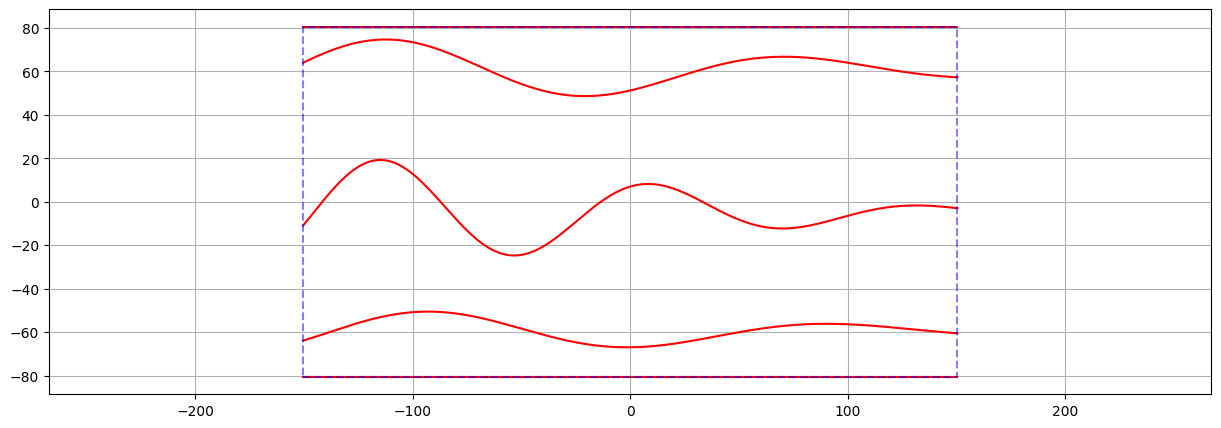

In [4]:
# Define three curves (crossing the grid)
x = np.linspace(xmin, xmax, 500)

# Curves from bottom to top
ycurve = []
y = ymin * np.ones_like(x)
ycurve.append(y)

u1, u2, u3, u4, u5, u6 = -60.0, 10.0, -150.0, 250.0, -50.0, 30.0
y = u1 + u2 * np.exp(-(((x-u3)/u4)**2)) * np.sin((u5 +x)/u6)
ycurve.append(y)

u1, u2, u3, u4, u5, u6 = -5.0, 25.0, -150.0, 200.0, 20.0, 20.0
y = u1 + u2 * np.exp(-(((x-u3)/u4)**2)) * np.sin((u5 +x)/u6)
ycurve.append(y)

u1, u2, u3, u4, u5, u6 = 60.0, 15.0, -150.0, 250.0, -30.0, 30.0
y = u1 + u2 * np.exp(-(((x-u3)/u4)**2)) * np.sin((u5 +x)/u6)
ycurve.append(y)

y = ymax * np.ones_like(x)
ycurve.append(y)

# Plot
plt.figure(figsize=(15,5))
for y in ycurve:
    plt.plot(x, y, c='red')
plt.plot([xmin, xmax, xmax, xmin, xmin], [ymin, ymin, ymax, ymax, ymin], ls='dashed', c='blue', alpha=.5)
plt.grid()
plt.axis('equal')
plt.show()

In [5]:
# Compute slope (derivate) along the curves and retrieve angles
#   angle: alpha = "minus mathematical angle in degrees"
acurve = [-np.arctan(np.diff(y)/np.diff(x))*180.0/np.pi for y in ycurve]

# ---- Optional -----
# - Change angle value by adding or substracting 180.0 (defining orientation in opposite direction, which is equivalent)
#     add 180.0 to negative angle and substract 180 to positive angle
# -> this creates "discontinuities" with "jump of 360" around angle near +/-180.0
# -> this is done to illustrate the interpolation of angles in a general situation (see below) 
acurve = [a+180.0*(a<0)-180.0*(a>=0) for a in acurve]
# -------------------

# Extract some points along the curves with the angles
jcurve = [np.arange(i0, len(acurve[i]), k) for i, (i0, k) in enumerate(zip([10, 5, 0, 7, 12], [50, 40, 30, 40, 50]))]
points = np.vstack([np.array((x[j], ycurve[i][j])).T for i, j in enumerate(jcurve)])
angles = np.hstack([acurve[i][j] for i, j in enumerate(jcurve)])

Plot the points with defined orientation.

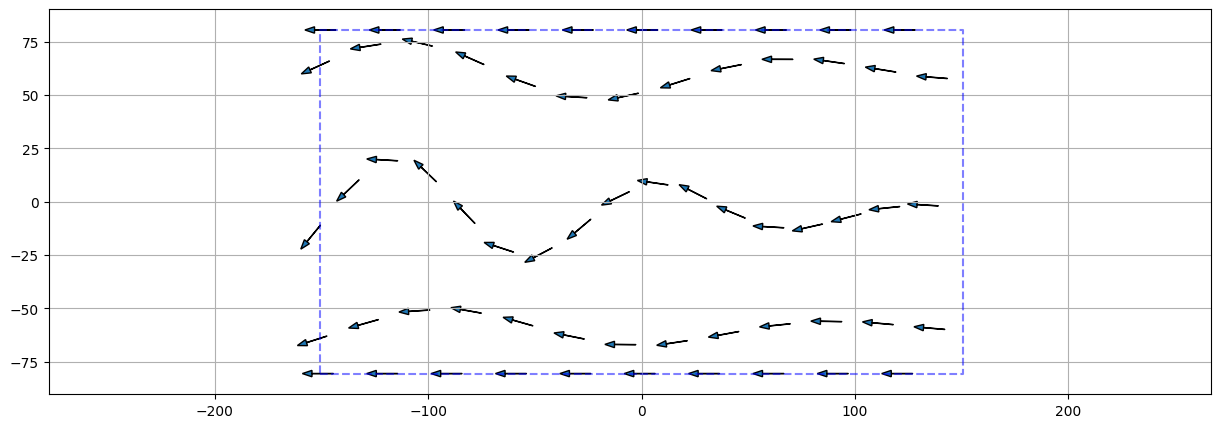

In [6]:
mrot = np.asarray([gn.covModel.rotationMatrix2D(ai) for ai in angles])
ax1 = mrot[:,:,0]

# Plot
plt.figure(figsize=(15,5))
vlen = 10.0
width = 0.1
head_width = 3.0
# for p, a1, an in zip(points, ax1, angles):
#     plt.arrow(p[0], p[1], vlen*a1[0], vlen*a1[1], width=width, head_width=head_width)
#     plt.text(p[0], p[1], an)
for p, a1 in zip(points, ax1):
    plt.arrow(p[0], p[1], vlen*a1[0], vlen*a1[1], width=width, head_width=head_width)
plt.plot([xmin, xmax, xmax, xmin, xmin], [ymin, ymin, ymax, ymax, ymin], ls='dashed', c='blue', alpha=.5)
plt.grid()
plt.axis('equal')
plt.show()

### 2. Krige the data set of alpha over the image grid (image `im_alpha`)

The interpolation in the image grid can be done by kriging with "smooth" covariance model. If the result is not satisfying, one can add points with orientation (point 1. above) and interpolate again.

Result of interpolation below is displayed with a map of angle values, and with a map with arrows at some point representing the orientation (using the function `alpha_loc_func`).

**Precautions for interpolating angles**

As two angles (in degrees) with a difference of (a multiple of) 360 represent the same orientation, some precautions have to be taken for the interpolation. If there is no "jump" of 360 between angle values at close points (i.e. no discontinuities), the angles can be interpolated directly; otherwise, and in general, one can interpolate the cosine and the sine of the angles, and then retrieve the angles over the image grid.

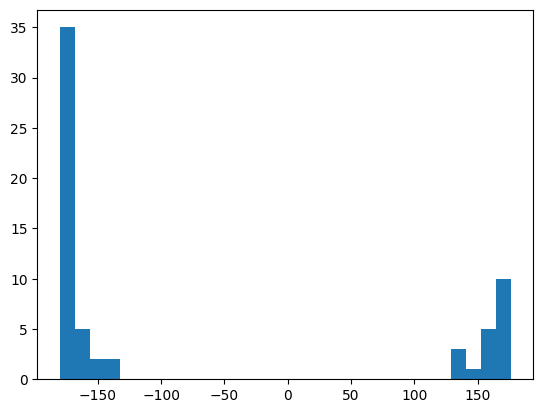

In [7]:
plt.figure()
plt.hist(angles, bins=30)
plt.show()

The histogram shows that there are discontinuities in the angles values; then the general approach is used.

estimate: Preprocessing data done: final number of data points : 63, inequality data points: 0
estimate: Computational resources: nthreads = 8, nproc_sgs_at_ineq = 8
estimate: (Step 1) No inequality data
estimate: (Step 2) Set new dataset gathering data and inequality data locations...
estimate: (Step 3) Do kriging at the center of grid cells containing at least one data point...
estimate: (Step 4) Do kriging on the grid (at cell centers) using data points at cell centers...
estimate: Geos-Classic running on 1 process... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 8 thread(s)]
run_MPDSOMPGeosClassicSim: Geos-Classic running... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 8 thread(s)]
run_MPDSOMPGeosClassicSim: Geos-Classic run complete
estimate: Geos-Classic (1 process) run complete
estimate: Preprocessing data done: final number of data points : 63, inequality data points: 0
estimate: Computational resources: nthreads = 8, nproc_sgs_at_ineq = 8
estimate: (Step 1) No inequality data

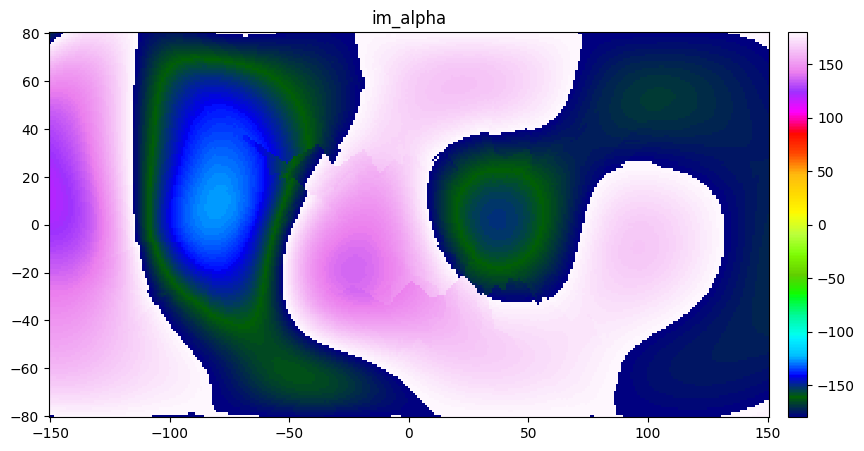

In [8]:
# Smooth covariance model
cov_model_angles = gn.covModel.CovModel2D(elem=[
    ('matern', {'w':1.0, 'r':[200, 200], 'nu':3.0}), # elementary contribution
    ], alpha=0.0, name='')

# Interpolate the cosine and the sine of the angles in the grid (smooth interpolation by kriging)
v = -np.pi/180.0*angles # angles in radians with mathematical convention
out = gn.geosclassicinterface.estimate(
                cov_model_angles, (nx, ny), (sx, sy), (ox, oy), 
                x=points, v=np.cos(v), 
                method='ordinary_kriging', 
                nneighborMax=32, searchRadiusRelative=1.0,
                #use_unique_neighborhood=True, 
                nthreads=8)
im_cos_alpha = out['image'] # image of cosine

out = gn.geosclassicinterface.estimate(
                cov_model_angles, (nx, ny), (sx, sy), (ox, oy), 
                x=points, v=np.sin(v),
                method='ordinary_kriging', 
                nneighborMax=32, searchRadiusRelative=1.0,
                #use_unique_neighborhood=True, 
                nthreads=8)
im_sin_alpha = out['image'] # image of sine

# Get the angles using the function arctan2, and set them in the format: "minus mathematical angle in degrees"
alpha = -180.0/np.pi*np.arctan2(im_sin_alpha.val, im_cos_alpha.val)
# Image of alpha angles
im_alpha = gn.img.copyImg(im_cos_alpha, varInd=[]) # copy the grid geometry only
im_alpha.append_var(alpha) # append variable

# Plot the angles
plt.figure(figsize=(15,5))
gn.imgplot.drawImage2D(im_alpha, iv=0, cmap='gist_ncar')
plt.title('im_alpha')
plt.show()

The angle map shows discontinuities (jump of "360" around +/-180), which is not problematic, because the orientations they represent vary smoothly ("continuously").

### Set the function `alpha_loc_func` from the image `im_alpha`
The class `geone.img.Img_interp_func` provides an interpolator (function) from the values of a variable at the centers of the grid cells of an image.

One can specify that the variable is an angle with the keyword argument `angle_var=True`, then the interpolator uses cosine and sine before retrieving the angle, to avoid problem with the discontinuities ("jump of 360 degrees"). If there is no such discontinuities, `angle_var=False` (default value) may be used.

In [9]:
# Set a function interpolating the value of the angle (given location)
alpha_loc_func = gn.img.Img_interp_func(im_alpha, ind=0, iz=0, angle_var=True)
    # Specify iz=0: consider only x, and y coordinates in the layer iz=0

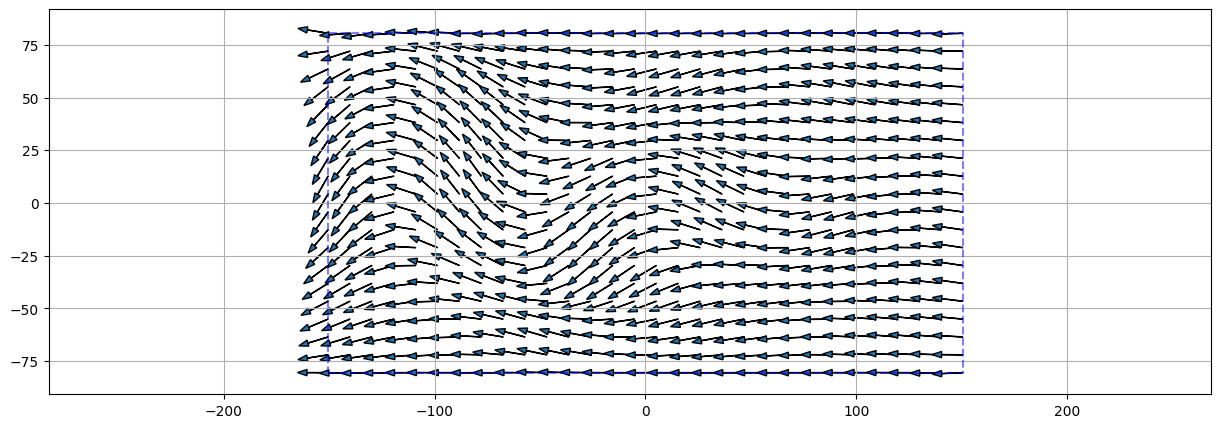

In [10]:
# Show the direction according to the angles alpha in some points of the grid
x1 = np.linspace(im_alpha.xmin(), im_alpha.xmax(), 30)
x2 = np.linspace(im_alpha.ymin(), im_alpha.ymax(), 20)

xx2, xx1 = np.meshgrid(x2, x1, indexing='ij')

points_grid = np.array((xx1.reshape(-1), xx2.reshape(-1))).T
angles_grid = alpha_loc_func(points_grid)
mrot = np.asarray([gn.covModel.rotationMatrix2D(ai) for ai in angles_grid])
ax1_grid = mrot[:,:,0]
#ax2 = mrot[:,:,1]

# Plot
plt.figure(figsize=(15,5))
vlen = 10.0
width = 0.1
head_width = 3.0
for p, a1 in zip(points_grid, ax1_grid):
    plt.arrow(p[0], p[1], vlen*a1[0], vlen*a1[1], width=width, head_width=head_width)
# for p, a in zip(points, angles):
#     plt.arrow(p[0], p[1], vlen*np.cos(-a*np.pi/180.0), vlen*np.sin(-a*np.pi/180.0), width=width, head_width=head_width)
plt.plot([xmin, xmax, xmax, xmin, xmin], [ymin, ymin, ymax, ymax, ymin], ls='dashed', c='blue', alpha=.5)
plt.grid()
plt.axis('equal')
plt.show()

### Defining non-stationary ranges
The factor (multiplier) for range `r_factor` locally varying in the grid is defined as `im_r_factor`: an image (with one variable on the grid).

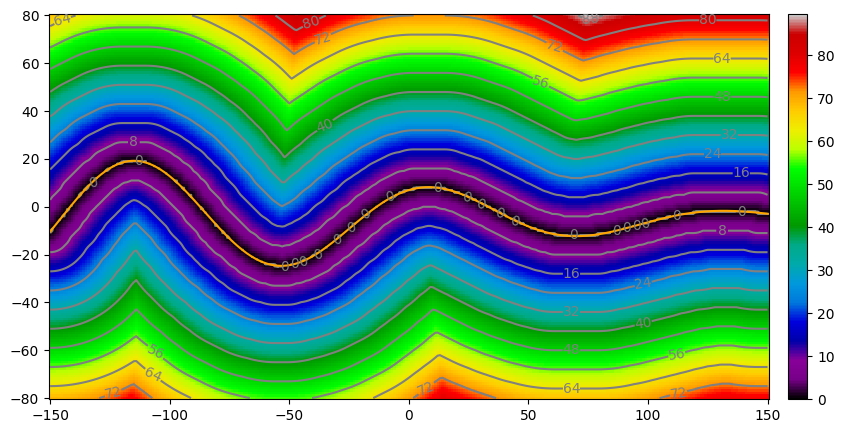

In [11]:
# Compute distance to the middle curve (x, ycurve[2]) above
im_line = gn.img.imageFromPoints(np.array((x, ycurve[2])).T, nx=nx, ny=ny, sx=sx, sy=sy, ox=ox, oy=oy, indicator_var=True)
im_line_dist = gn.geosclassicinterface.imgDistanceImage(im_line, distance_type='L2')

# Plot
plt.figure(figsize=(15,5))
gn.imgplot.drawImage2D(im_line_dist, cmap='nipy_spectral', levels=12, contour=True, contour_clabel=True)
plt.plot(x, ycurve[2], color='orange')
plt.show()

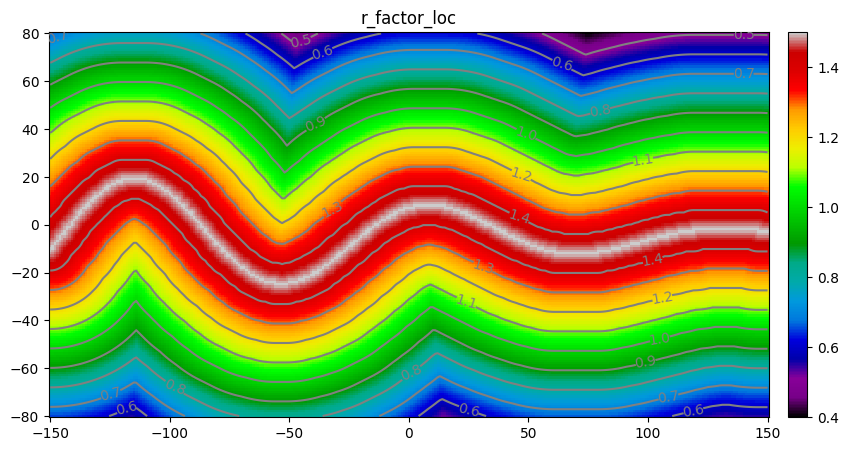

In [12]:
# Define r_factor as r0 on the middle curve and decreasing linearly wrt the distance above
r0 = 1.5 # on the middle curve
r1 = 0.4 # minimal value
d = im_line_dist.val[0] # distance map
r = r0 + d/d.max() * (r1-r0)

im_r_factor = gn.img.copyImg(im_line_dist)
im_r_factor.val = r0 + im_r_factor.val/im_r_factor.val.max() * (r1-r0)

# Plot
plt.figure(figsize=(15,5))
gn.imgplot.drawImage2D(im_r_factor, cmap='nipy_spectral', levels=12, contour=True, contour_clabel=True)
plt.title('r_factor_loc')
plt.show()

### Defining non-stationary variance (sill)
The factor (multiplier) for the total weight (variance, sill) `w_factor` locally varying in the grid is defined as `im_w_factor`: an image (with one variable on the grid).

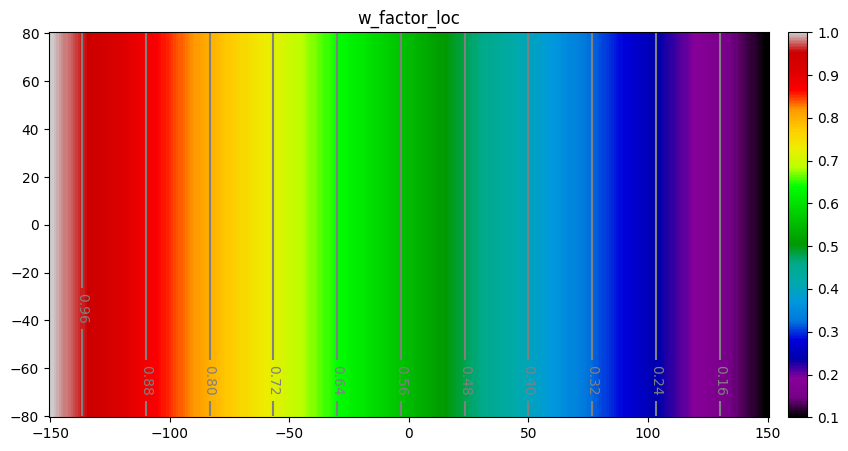

In [13]:
# Define w_factor as w0 on the left of the grid and decreasing linearly when going to the right of the grid
w0 = 1.0 # on the left
w1 = 0.1 # minimal value

# "Empty" image
im_w_factor = gn.img.Img(nx, ny, 1, sx, sy, 1., ox, oy, 0., nv=0)

# Add variable
w = w0 + (im_w_factor.xx()-im_w_factor.xx().min())/(im_w_factor.xx().max()-im_w_factor.xx().min()) * (w1-w0)
im_w_factor.append_var(w)

# Plot
plt.figure(figsize=(15,5))
gn.imgplot.drawImage2D(im_w_factor, cmap='nipy_spectral', levels=12, contour=True, contour_clabel=True)
plt.title('w_factor_loc')
plt.show()

## II Non-stationary simulations
First define a reference covariance model and generate an unconditional simulation (reference). Then build a data set by extract some points from the simulation. Then, ignoring the covariance model and starting from the data set and the maps controlling the non-stationary features:

- fit a covariance model
- do kriging / conditional simulations

Several cases are proposed below with different non-stationary features.

## A. Non-stationary orientation

### Reference covariance model and non-stationarity
Define first a *stationary* anisotropic reference covariance model in 2D. Then, add the desired non-stationarity feature.

In [14]:
# Define a base covariance model (stationary)
cov_model_base = gn.covModel.CovModel2D(elem=[
    ('cubic', {'w':10, 'r':[30., 5.]}), # elementary contribution
    ], alpha=0.0, name='ref')

# Define the functions `alpha_loc_func`, (resp. `alpha_loc_func_xy`) and that returns the angle(s) 
# alpha at given location(s) from one parameter: point(s) in 2D (resp. two parameters: x, y coordinate(s))
alpha_loc_func = gn.img.Img_interp_func(im_alpha, ind=0, iz=0, angle_var=True)
    # Specify iz=0: consider only x, and y coordinates in the layer iz=0

def alpha_loc_func_xy(x, y):
    x = np.atleast_1d(x)
    y = np.atleast_1d(y)
    return alpha_loc_func(np.vstack((x.reshape(-1), y.reshape(-1))).T).reshape(x.shape)

# This function will be used to set non-stationary orientation (see below)

### Do an unconditional simulation (reference)

simulate: Preprocessing data done: final number of data points : 0, inequality data points: 0
simulate: Computational resources: nproc = 1, nthreads_per_proc = 8, nproc_sgs_at_ineq = 8
simulate: (Step 1-3 skipped) No data
simulate: (Step 4) Do sgs (1 realizations) on the grid (at cell centers) using data points at cell centers...
simulate: Geos-Classic running on 1 process... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 8 thread(s)]
run_MPDSOMPGeosClassicSim: Geos-Classic running... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 8 thread(s)]
run_MPDSOMPGeosClassicSim: Geos-Classic run complete
simulate: Geos-Classic (1 process) run complete
simulate: warnings encountered (57 times in all):
#  1: WARNING 02001: a neigbhor has been dropped (solving kriging system)


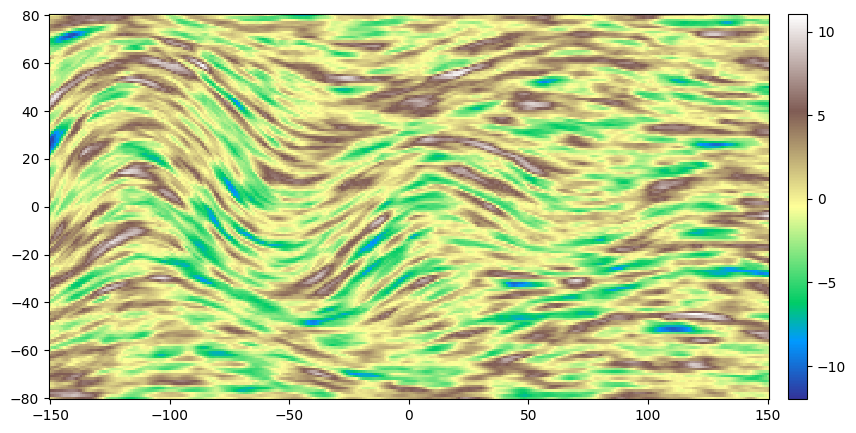

In [15]:
# Simulation
nreal = 1
np.random.seed(2332)
geosclassic_output = gn.geosclassicinterface.simulate(
                        cov_model_base, (nx, ny), (sx, sy), (ox, oy), 
                        method='simple_kriging', 
                        alpha=alpha_loc_func_xy,
                        nneighborMax=20, 
                        nreal=nreal, 
                        nproc=1, nthreads_per_proc=8)

im_ref = geosclassic_output['image']

plt.figure(figsize=(15,5))
gn.imgplot.drawImage2D(im_ref, cmap='terrain')
plt.show()

### Build a non-stationary data set (2D)

The data set is defined by extracting some points from the simulation of reference.

*Note:* the data set should contain enough points to catch the non-stationarities.

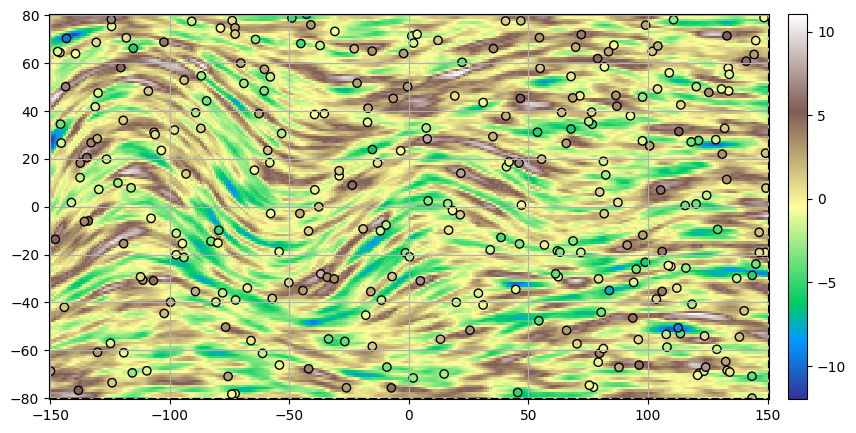

In [16]:
# Extract som points from the simulation
n = 300

# --- Choose 1. or 2. below ---
# # 1. Sampling the image
# ps = gn.img.sampleFromImage(im_ref, n, seed=234)
# # Data points and data value
# x = np.array((ps.x(), ps.y())).T
# v = ps.val[3]
# # Optionally: move points in the grid cells randomly, and add noise to values
# x[:, 0] = x[:, 0] + (np.random.random(n)-0.5)* im_ref.sx
# x[:, 1] = x[:, 1] + (np.random.random(n)-0.5)* im_ref.sy
# v = v + (np.random.random(n)-0.5)* 1.e-1

# 2. Using the function interpolating the image values
f = gn.img.Img_interp_func(im_ref, iz=0)
np.random.seed(658)
x1 = im_ref.xmin() + np.random.random(n) * (im_ref.xmax()-im_ref.xmin())
x2 = im_ref.ymin() + np.random.random(n) * (im_ref.ymax()-im_ref.ymin())
x = np.array((x1, x2)).T
v = f(x)
# ----- #

plt.figure(figsize=(15,5))
gn.imgplot.drawImage2D(im_ref, cmap='terrain')

plt.scatter(x[:,0], x[:,1], c=v, edgecolors='black', cmap='terrain', vmin=im_ref.vmin()[0], vmax=im_ref.vmax()[0])
plt.plot([xmin, xmax, xmax, xmin, xmin], [ymin, ymin, ymax, ymax, ymin], ls='dashed', c='black')
#plt.colorbar()
plt.axis('equal')
plt.grid()
plt.show()

### Simulation starting from a non-stationary data set in 2D and assuming "non-stationarity feature(s)" known

- `n`: number of data points
- `x`: location of data points (2-dimensional array of shape `(n, 2)`, each row is a point)
- `v`: values at data points (1-dimensional array of length `n`)
- `im_alpha`: image of the angle `alpha` in the grid; the function `alpha_loc_func` (resp. `alpha_loc_func_xy`) which is an interpolator of `alpha` in the grid taking one parameter, points in 2D (resp. two parameters, the x and y coordinates of points in 2D)

### Fitting covariance model accounting for non-stationarity

In [17]:
cov_model_to_optimize = gn.covModel.CovModel2D(elem=[
        ('cubic', {'w':np.nan, 'r':[np.nan, np.nan]}), # elementary contribution
         ], alpha=0.0, name='') # alpha is set to 0.0, non-sationarity is handled by alpha_loc_func below

t1 = time.time()
cov_model_opt, popt = gn.covModel.covModel2D_fit(
                x, v, cov_model_to_optimize, 
                alpha_loc_func=alpha_loc_func, # deal with non-stationarity (angle alpha)
                loc_m=1, # loc_m > 0: number of sub-intervals btw pair of points to estimate local function (default 1)
                         # loc_m = 0: take factor from one point
                bounds=([ 0,  0,  0],  # min value for param. to fit
                        [40, 80, 80]), # max value for param. to fit
                hmax=None, make_plot=False) # figure size for plot
t2 = time.time()
print(f'Fitting covariance model - elapsed time: {t2-t1:.4g} sec')

cov_model_opt

Fitting covariance model - elapsed time: 0.5003 sec


*** CovModel2D object ***
name = ''
number of elementary contribution(s): 1
elementary contribution 0
    type: cubic
    parameters:
        w = 9.340259359967353
        r = [np.float64(36.24014828160089), np.float64(4.347056952256998)]
angle: alpha = 0.0 deg.
    i.e.: the system Ox'y', supporting the axes of the model (ranges),
    is obtained from the system Oxy by applying a rotation of angle -alpha.
*****

#### Cross-validation by leave-one-out error

----- CRPS (negative; the larger, the better) -----
   mean = -1.71
   def. = -0.7124
----- 1) "Normal law test for mean of normalized error" -----
   p-value = 0.9153
   success = True (wrt significance level 0.05)
      (-> model has no reason to be rejected)
----- 2) "Chi-square test for sum of squares of normalized error" -----
   p-value = 0.2056
   success = True (wrt significance level 0.05)
      (-> model has no reason to be rejected)
----- Statistics of normalized error -----
   mean     = -0.00614 (should be close to 0)
   std      = 1.033 (should be close to 1)
   skewness = -0.05643 (should be close to 0)
   excess kurtosis = 0.1775 (should be close to 0)


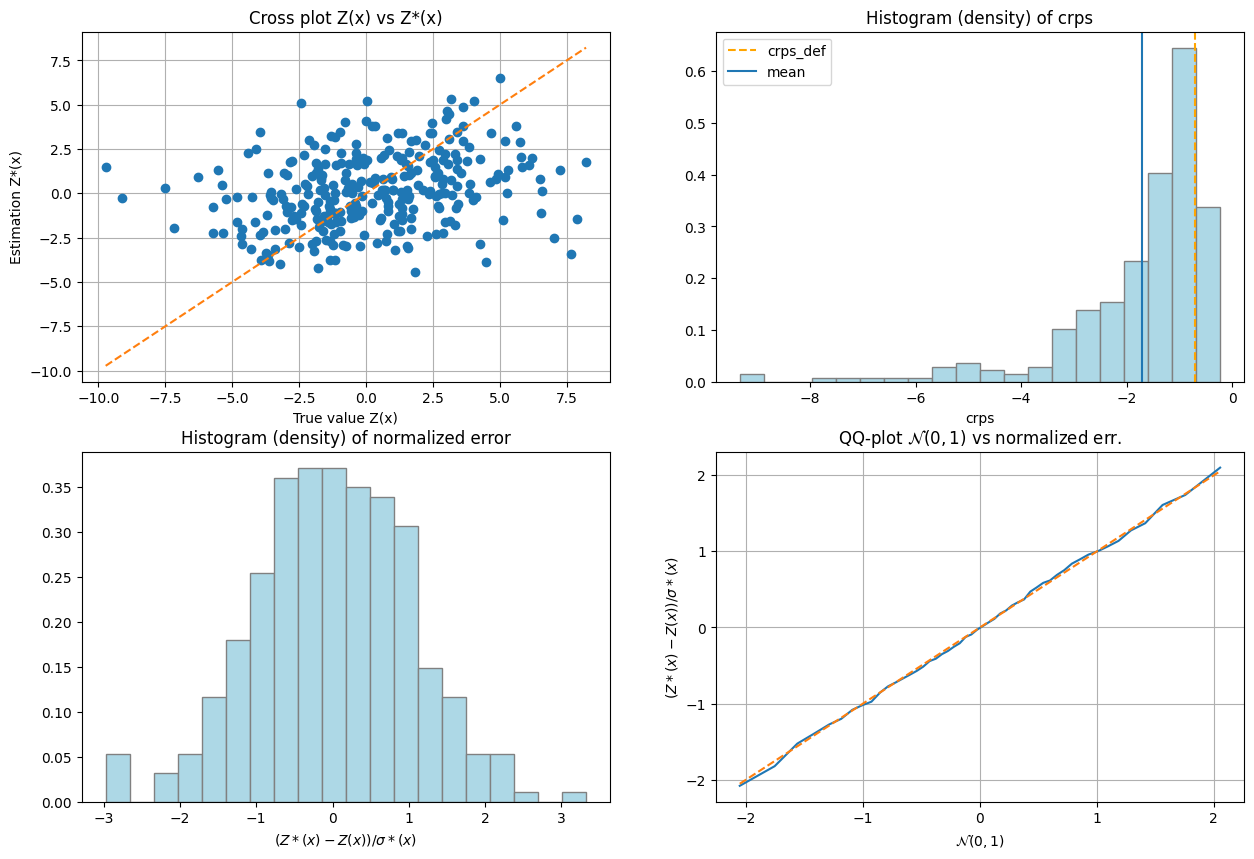

In [18]:
# Interpolation by simple kriging
cv_est1, cv_std1, crps1, crps_def1, pvalue1, success1 = gn.covModel.cross_valid_loo(
                                        x, v, cov_model_opt,
                                        interpolator=gn.covModel.krige, 
                                        interpolator_kwargs={'method':'ordinary_kriging'},
                                        alpha_x=alpha_loc_func(x), # specify angle at data points
                                        print_result=True, make_plot=True, figsize=(15,10), nbins=20)
plt.show()

### Show experimental variogram, fitted model and reference model

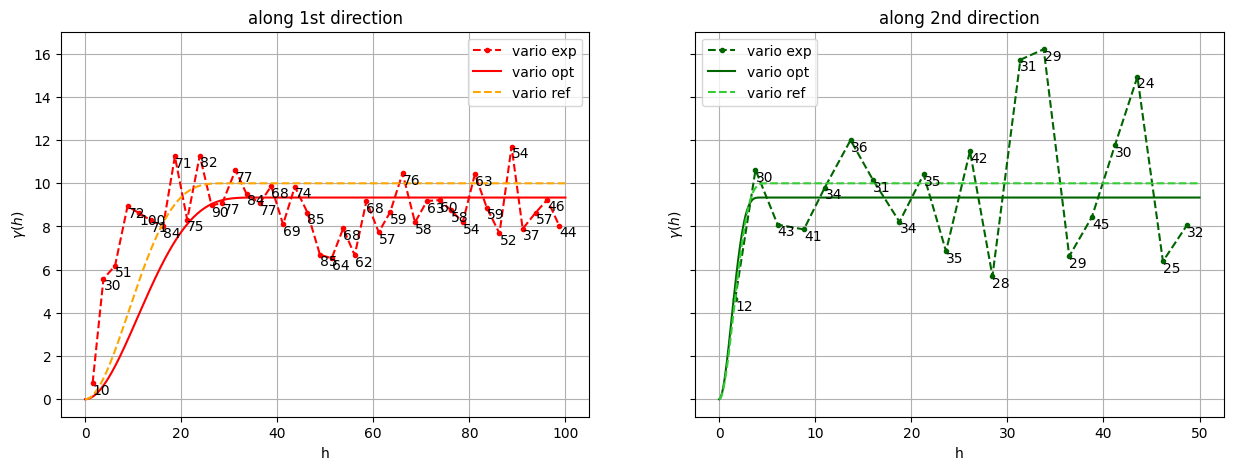

In [19]:
hmax1, hmax2 = 100.0, 50.0

(hexp1, gexp1, cexp1), (hexp2, gexp2, cexp2) = gn.covModel.variogramExp2D(
                x, v, alpha=0, hmax=(hmax1, hmax2), 
                alpha_loc_func=alpha_loc_func, loc_m=0,
                ncla=(40, 20), make_plot=False)

plt.subplots(1,2, sharey=True, figsize=(15,5))
plt.subplot(1,2,1)
gn.covModel.plot_variogramExp1D(hexp1, gexp1, cexp1, c='red', label='vario exp')
cov_model_opt.plot_model_one_curve(vario=True, main_axis=1, hmax=hmax1, c='red', label='vario opt')
cov_model_base.plot_model_one_curve(vario=True, main_axis=1, hmax=hmax1, c='orange', ls='dashed', label='vario ref')
plt.legend()
plt.title("along 1st direction")

plt.subplot(1,2,2)
gn.covModel.plot_variogramExp1D(hexp2, gexp2, cexp2, c='darkgreen', label='vario exp')
cov_model_opt.plot_model_one_curve(vario=True, main_axis=2, hmax=hmax2, c='darkgreen', label='vario opt')
cov_model_base.plot_model_one_curve(vario=True, main_axis=2, hmax=hmax2, c='limegreen', ls='dashed', label='vario ref')
plt.legend()
plt.title("along 2nd direction")

plt.show()

### Kriging and conditional simulations

In [20]:
# Kriging
t1 = time.time() # start time
geosclassic_output = gn.geosclassicinterface.estimate(
                            cov_model_opt, (nx, ny), (sx, sy), (ox, oy),
                            x=x, v=v,
                            method='ordinary_kriging', 
                            nneighborMax=20, 
                            alpha=alpha_loc_func_xy,
                            nthreads=8)
t2 = time.time() # end time
print(f'Kriging - elapsed time: {t2-t1:.4g} sec')

# Retrieve kriging estimate and standard deviation
im_krig = geosclassic_output['image']

estimate: Preprocessing data done: final number of data points : 299, inequality data points: 0
estimate: Computational resources: nthreads = 8, nproc_sgs_at_ineq = 8
estimate: (Step 1) No inequality data
estimate: (Step 2) Set new dataset gathering data and inequality data locations...
estimate: (Step 3) Do kriging at the center of grid cells containing at least one data point...
estimate: (Step 4) Do kriging on the grid (at cell centers) using data points at cell centers...
estimate: Geos-Classic running on 1 process... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 8 thread(s)]
run_MPDSOMPGeosClassicSim: Geos-Classic running... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 8 thread(s)]
run_MPDSOMPGeosClassicSim: Geos-Classic run complete
estimate: Geos-Classic (1 process) run complete
Kriging - elapsed time: 0.2734 sec


In [21]:
# Simulation
nreal = 50
np.random.seed(22131)
t1 = time.time() # start time
geosclassic_output = gn.geosclassicinterface.simulate(
                            cov_model_opt, 
                            (nx, ny), (sx, sy), (ox, oy), 
                            x=x, v=v, method='ordinary_kriging', 
                            nneighborMax=20, 
                            alpha=alpha_loc_func_xy,
                            nreal=nreal,
                            nproc=4, nthreads_per_proc=4)
t2 = time.time() # end time
print(f'{nreal} simul. - elapsed time: {t2-t1:.4g} sec')

# Retrieve the realizations
simul = geosclassic_output['image']

# Compute mean and standard deviation (pixel-wise)
simul_mean = gn.img.imageContStat(simul, op='mean')
simul_std = gn.img.imageContStat(simul, op='std')

simulate: Preprocessing data done: final number of data points : 299, inequality data points: 0
simulate: Computational resources: nproc = 4, nthreads_per_proc = 4, nproc_sgs_at_ineq = 16
simulate: (Step 1) No inequality data
simulate: (Step 2) Set new dataset gathering data and inequality data locations...
simulate: (Step 3) Do kriging at the center of grid cells containing at least one data point...
simulate: (Step 4) Do sgs (50 realizations) on the grid (at cell centers) using data points at cell centers...
simulate: Geos-Classic running on 4 process(es)... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 4 thread(s)]
run_MPDSOMPGeosClassicSim [pid=0]: Geos-Classic running... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 4 thread(s)]
run_MPDSOMPGeosClassicSim [pid=0]: Geos-Classic run complete
simulate: Geos-Classic (4 process(es)) run complete
50 simul. - elapsed time: 5.265 sec


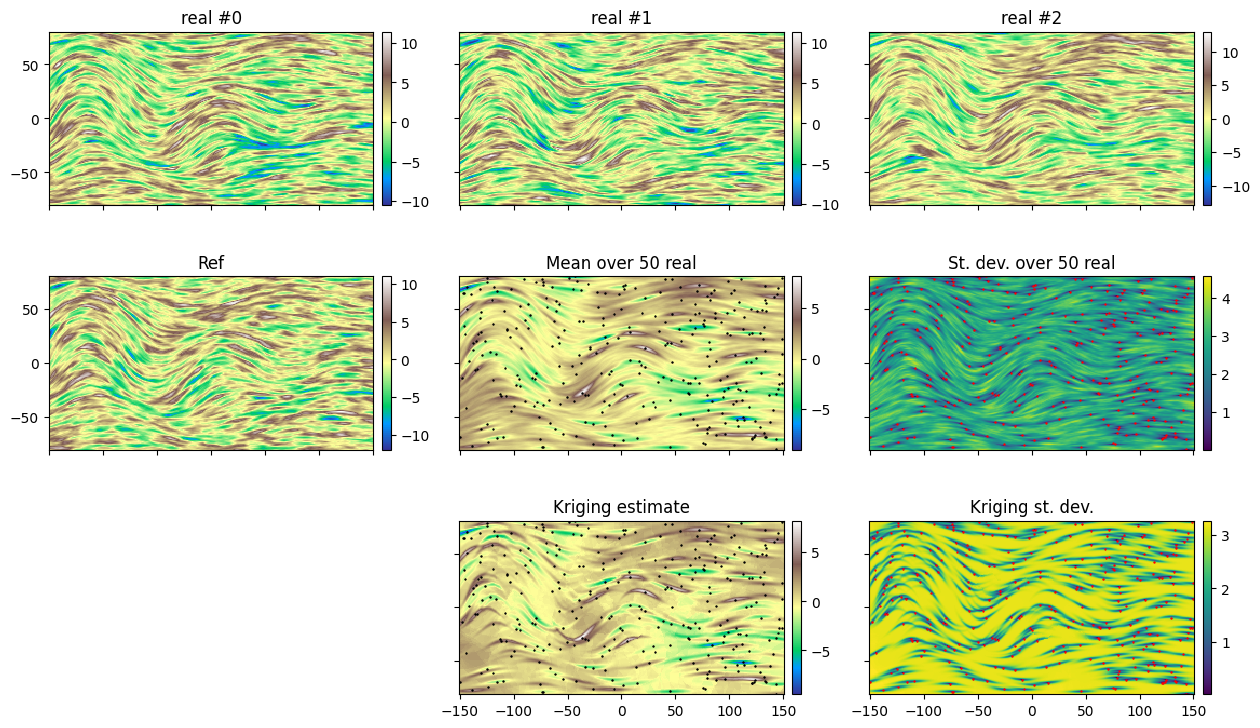

In [22]:
cmap = 'terrain'

# Plot
fig, ax = plt.subplots(3, 3, figsize=(15, 9), sharex=True, sharey=True)

# 3 first real ...
for i in (0, 1, 2):
    plt.subplot(3, 3, i+1)
    gn.imgplot.drawImage2D(simul, iv=i, cmap=cmap)
    #plt.plot(x[:,0],x[:,1], '+', c='black', markersize=10) # add conditioning point locations
    plt.title('real #{}'.format(i))

# ref 
plt.subplot(3, 3, 4)
gn.imgplot.drawImage2D(im_ref, cmap=cmap)
#plt.plot(x[:,0],x[:,1], '+', c='black', markersize=10) # add conditioning point locations
plt.title('Ref')

# mean of all real
plt.subplot(3, 3, 5)
gn.imgplot.drawImage2D(simul_mean, cmap=cmap)
plt.plot(x[:,0],x[:,1], '+', c='black', markersize=2) # add conditioning point locations
plt.title('Mean over {} real'.format(nreal))

# standard deviation of all real
plt.subplot(3, 3, 6)
gn.imgplot.drawImage2D(simul_std, cmap='viridis')
plt.plot(x[:,0],x[:,1], '+', c='red', markersize=2) # add conditioning point locations
plt.title('St. dev. over {} real'.format(nreal))

plt.subplot(3, 3, 7)
plt.axis('off')

# kriging estimate
plt.subplot(3, 3, 8)
gn.imgplot.drawImage2D(im_krig, iv=0, cmap=cmap)
plt.plot(x[:,0],x[:,1], '+', c='black', markersize=2) # add conditioning point locations
plt.title('Kriging estimate')

# kriging standard deviation
plt.subplot(3, 3, 9)
gn.imgplot.drawImage2D(im_krig, iv=1, cmap='viridis')
plt.plot(x[:,0],x[:,1], '+', c='red', markersize=2) # add conditioning point locations
plt.title('Kriging st. dev.')

plt.show()

## B1. Non-stationary range along each axis

### Reference covariance model and non-stationarity
Define first a *stationary* anisotropic reference covariance model in 2D. Then, add the desired non-stationarity feature.

In [23]:
# Define a base covariance model (stationary)
cov_model_base = gn.covModel.CovModel2D(elem=[
    ('cubic', {'w':10, 'r':[30., 5.]}), # elementary contribution
    ], alpha=0.0, name='ref')

# Set list to handle non-stationarities
cov_model_non_stationarity_list = [
    ('multiply_r', im_r_factor.val[0]), # multiply range by `im_r_factor.val[0]` over the grid
]


### Do an unconditional simulation (reference)

simulate: Preprocessing data done: final number of data points : 0, inequality data points: 0
simulate: Computational resources: nproc = 1, nthreads_per_proc = 8, nproc_sgs_at_ineq = 8
simulate: (Step 1-3 skipped) No data
simulate: (Step 4) Do sgs (1 realizations) on the grid (at cell centers) using data points at cell centers...
simulate: Geos-Classic running on 1 process... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 8 thread(s)]
run_MPDSOMPGeosClassicSim: Geos-Classic running... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 8 thread(s)]
run_MPDSOMPGeosClassicSim: Geos-Classic run complete
simulate: Geos-Classic (1 process) run complete
simulate: warnings encountered (6 times in all):
#  1: WARNING 02001: a neigbhor has been dropped (solving kriging system)


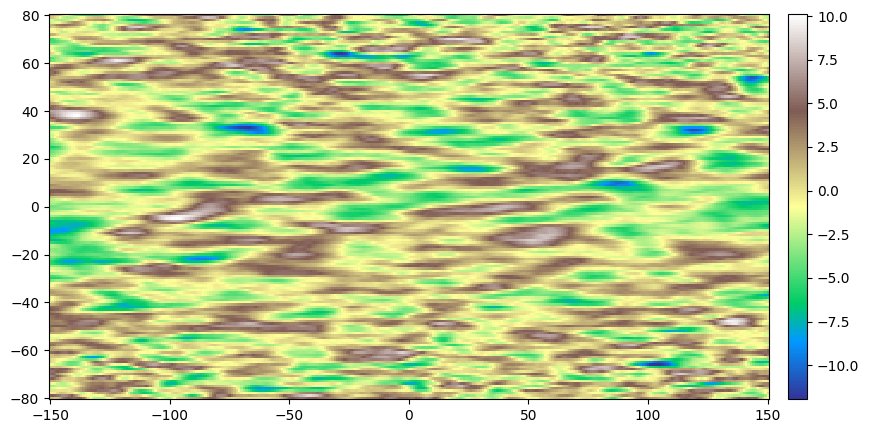

In [24]:
# Simulation
nreal = 1
np.random.seed(85)
geosclassic_output = gn.geosclassicinterface.simulate(
                        cov_model_base, (nx, ny), (sx, sy), (ox, oy),
                        method='simple_kriging', 
                        cov_model_non_stationarity_list=cov_model_non_stationarity_list,
                        nneighborMax=20, 
                        nreal=nreal, 
                        nproc=1, nthreads_per_proc=8)

im_ref = geosclassic_output['image']

plt.figure(figsize=(15,5))
gn.imgplot.drawImage2D(im_ref, cmap='terrain')
plt.show()

### Build a non-stationary data set (2D)

The data set is defined by extracting some points from the simulation of reference.

*Note:* the data set should contain enough points to catch the non-stationarities.

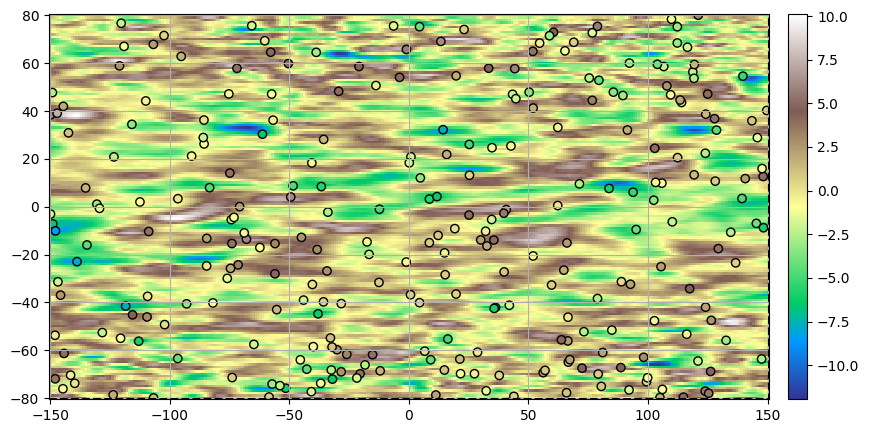

In [25]:
# Extract som points from the simulation
n = 280

# --- Choose 1. or 2. below ---
# # 1. Sampling the image
# ps = gn.img.sampleFromImage(im_ref, n, seed=234)
# # Data points and data value
# x = np.array((ps.x(), ps.y())).T
# v = ps.val[3]
# # Optionally: move points in the grid cells randomly, and add noise to values
# x[:, 0] = x[:, 0] + (np.random.random(n)-0.5)* im_ref.sx
# x[:, 1] = x[:, 1] + (np.random.random(n)-0.5)* im_ref.sy
# v = v + (np.random.random(n)-0.5)* 1.e-1

# 2. Using the function interpolating the image values
f = gn.img.Img_interp_func(im_ref, iz=0)
np.random.seed(987)
x1 = im_ref.xmin() + np.random.random(n) * (im_ref.xmax()-im_ref.xmin())
x2 = im_ref.ymin() + np.random.random(n) * (im_ref.ymax()-im_ref.ymin())
x = np.array((x1, x2)).T
v = f(x)
# ----- #

plt.figure(figsize=(15,5))
gn.imgplot.drawImage2D(im_ref, cmap='terrain')

plt.scatter(x[:,0], x[:,1], c=v, edgecolors='black', cmap='terrain', vmin=im_ref.vmin()[0], vmax=im_ref.vmax()[0])
plt.plot([xmin, xmax, xmax, xmin, xmin], [ymin, ymin, ymax, ymax, ymin], ls='dashed', c='black')
#plt.colorbar()
plt.axis('equal')
plt.grid()
plt.show()

### Simulation starting from a non-stationary data set in 2D and assuming "non-stationarity feature(s)" known

- `n`: number of data points
- `x`: location of data points (2-dimensional array of shape `(n, 2)`, each row is a point)
- `v`: values at data points (1-dimensional array of length `n`)
- `im_r_factor`: image of the factor (multiplier) `r_factor` in the grid; the function `r_factor_inv_loc_func` (interpolator of the inverse of `r_factor` in the grid) is built from this image

In [26]:
# Set a function interpolating the inverse of the r_factor (given location)
im_tmp = gn.img.copyImg(im_r_factor)
im_tmp.val = 1.0/im_tmp.val
r_factor_inv_loc_func = gn.img.Img_interp_func(im_tmp, ind=0, iz=0) 
# -> specify iz=0: consider only x and y coordinates in the layer iz=0

### Fitting covariance model accounting for non-stationarity

In [27]:
cov_model_to_optimize = gn.covModel.CovModel2D(elem=[
        ('cubic', {'w':np.nan, 'r':[np.nan, np.nan]}), # elementary contribution
         ], alpha=0.0, name='')

t1 = time.time()
cov_model_opt, popt = gn.covModel.covModel2D_fit(
                x, v, cov_model_to_optimize, 
                coord1_factor_loc_func=r_factor_inv_loc_func, 
                coord2_factor_loc_func=r_factor_inv_loc_func, 
                         # deal with non-stationarity (multiplier for range along each axis)
                loc_m=1, # loc_m > 0: number of sub-intervals btw pair of points to estimate local function (default 1)
                         # loc_m = 0: take factor from one point
                bounds=([ 0,  0,  0],  # min value for param. to fit
                        [40, 80, 80]), # max value for param. to fit
                hmax=None, make_plot=False) # figure size for plot
t2 = time.time()
print(f'Fitting covariance model - elapsed time: {t2-t1:.4g} sec')

cov_model_opt

Fitting covariance model - elapsed time: 0.2807 sec


*** CovModel2D object ***
name = ''
number of elementary contribution(s): 1
elementary contribution 0
    type: cubic
    parameters:
        w = 9.992328377974637
        r = [np.float64(59.184462636938676), np.float64(5.441337573119708)]
angle: alpha = 0.0 deg.
    i.e.: the system Ox'y', supporting the axes of the model (ranges),
    is obtained from the system Oxy by applying a rotation of angle -alpha.
*****

#### Cross-validation by leave-one-out error

----- CRPS (negative; the larger, the better) -----
   mean = -1.67
   def. = -0.7362
----- 1) "Normal law test for mean of normalized error" -----
   p-value = 0.7713
   success = True (wrt significance level 0.05)
      (-> model has no reason to be rejected)
----- 2) "Chi-square test for sum of squares of normalized error" -----
   p-value = 8.726e-13
   success = False (wrt significance level 0.05)
      -> model should be REJECTED
----- Statistics of normalized error -----
   mean     = 0.01737 (should be close to 0)
   std      = 1.31 (should be close to 1)
   skewness = -0.1539 (should be close to 0)
   excess kurtosis = 0.9375 (should be close to 0)


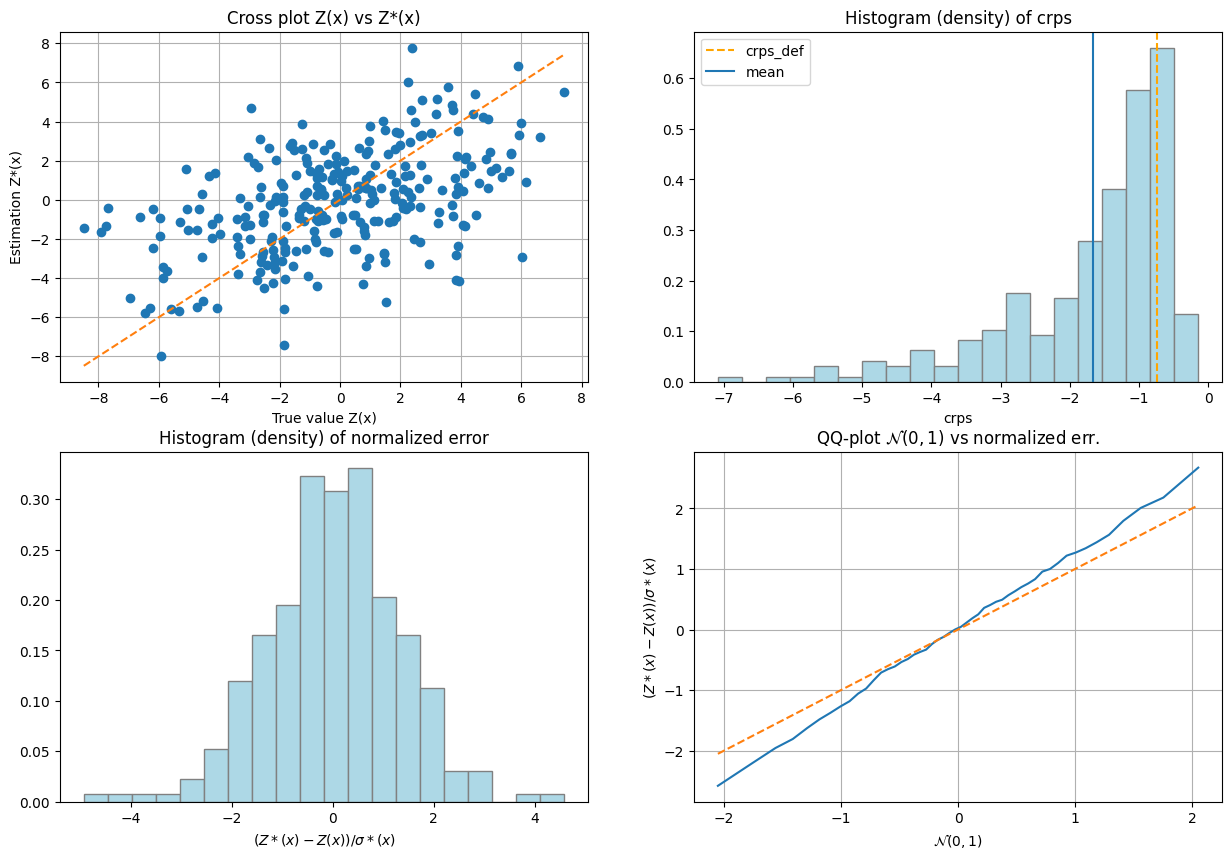

In [28]:
# Set a function interpolating the r_factor (given location)
r_factor_loc_func = gn.img.Img_interp_func(im_r_factor, ind=0, iz=0) 
# -> specify iz=0: consider only x and y coordinates in the layer iz=0

# Set list to handle non-stationarities at x
cov_model_non_stationarity_x_list = [
    ('multiply_r', r_factor_loc_func(x))
]

# Interpolation by simple kriging
cv_est1, cv_std1, crps1, crps_def1, pvalue1, success1 = gn.covModel.cross_valid_loo(
                                        x, v, cov_model_opt,
                                        interpolator=gn.covModel.krige, 
                                        interpolator_kwargs={'method':'ordinary_kriging'},
                                        cov_model_non_stationarity_x_list=cov_model_non_stationarity_x_list,
                                        print_result=True, make_plot=True, figsize=(15,10), nbins=20)
plt.show()

### Show experimental variogram, fitted model and reference model

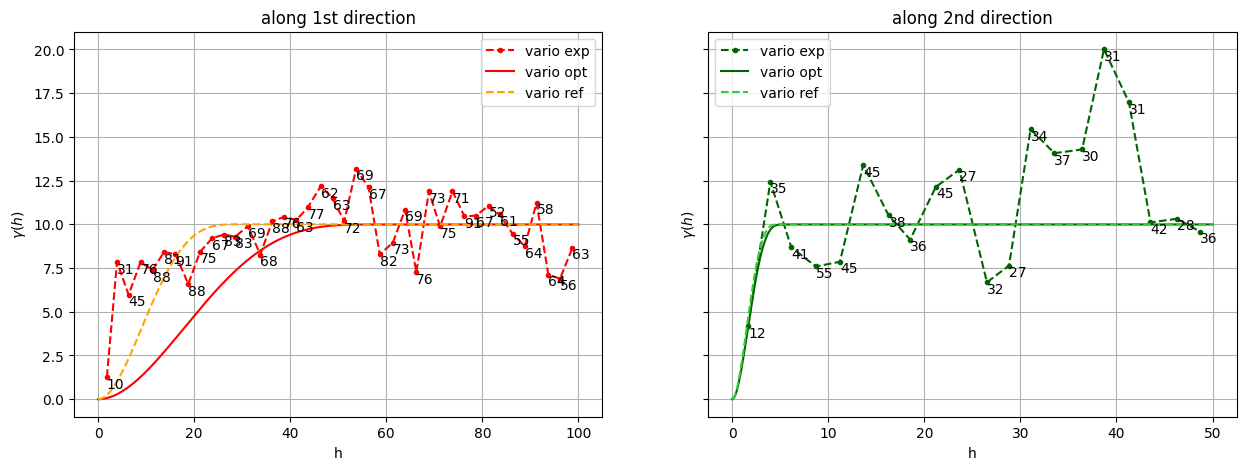

In [29]:
hmax1, hmax2 = 100.0, 50.0

(hexp1, gexp1, cexp1), (hexp2, gexp2, cexp2) = gn.covModel.variogramExp2D(
            x, v, alpha=0, hmax=(hmax1, hmax2),
            coord1_factor_loc_func=r_factor_inv_loc_func, coord2_factor_loc_func=r_factor_inv_loc_func,  loc_m=1,
            ncla=(40, 20), make_plot=False)

plt.subplots(1,2, sharey=True, figsize=(15,5))
plt.subplot(1,2,1)
gn.covModel.plot_variogramExp1D(hexp1, gexp1, cexp1, c='red', label='vario exp')
cov_model_opt.plot_model_one_curve(vario=True, main_axis=1, hmax=hmax1, c='red', label='vario opt')
cov_model_base.plot_model_one_curve(vario=True, main_axis=1, hmax=hmax1, c='orange', ls='dashed', label='vario ref')
plt.legend()
plt.title("along 1st direction")

plt.subplot(1,2,2)
gn.covModel.plot_variogramExp1D(hexp2, gexp2, cexp2, c='darkgreen', label='vario exp')
cov_model_opt.plot_model_one_curve(vario=True, main_axis=2, hmax=hmax2, c='darkgreen', label='vario opt')
cov_model_base.plot_model_one_curve(vario=True, main_axis=2, hmax=hmax2, c='limegreen', ls='dashed', label='vario ref')
plt.legend()
plt.title("along 2nd direction")

plt.show()

### Kriging and conditional simulations

In [30]:
# Kriging
t1 = time.time() # start time
geosclassic_output = gn.geosclassicinterface.estimate(
                        cov_model_opt, (nx, ny), (sx, sy), (ox, oy), 
                        x=x, v=v, 
                        method='simple_kriging', 
                        cov_model_non_stationarity_list=cov_model_non_stationarity_list,
                        nneighborMax=20,
                        nthreads=8)
t2 = time.time() # end time
print(f'Kriging - elapsed time: {t2-t1:.4g} sec')

# Retrieve kriging estimate and standard deviation
im_krig = geosclassic_output['image']

estimate: Preprocessing data done: final number of data points : 280, inequality data points: 0
estimate: Computational resources: nthreads = 8, nproc_sgs_at_ineq = 8
estimate: (Step 1) No inequality data
estimate: (Step 2) Set new dataset gathering data and inequality data locations...
estimate: (Step 3) Do kriging at the center of grid cells containing at least one data point...
estimate: (Step 4) Do kriging on the grid (at cell centers) using data points at cell centers...
estimate: Geos-Classic running on 1 process... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 8 thread(s)]
run_MPDSOMPGeosClassicSim: Geos-Classic running... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 8 thread(s)]
run_MPDSOMPGeosClassicSim: Geos-Classic run complete
estimate: Geos-Classic (1 process) run complete
estimate: warnings encountered (1215 times in all):
#  1: WARNING 02001: a neigbhor has been dropped (solving kriging system)
#  2: WARNING 02015: solving kriging system fails (do as if no neighbor)
Kri

In [31]:
# Simulation
nreal = 50
np.random.seed(22131)
t1 = time.time() # start time
geosclassic_output = gn.geosclassicinterface.simulate(
                        cov_model_opt, (nx, ny), (sx, sy), (ox, oy), 
                        x=x, v=v, 
                        method='simple_kriging', 
                        cov_model_non_stationarity_list=cov_model_non_stationarity_list,
                        nneighborMax=20,
                        nreal=nreal,
                        nproc=2, nthreads_per_proc=4)
t2 = time.time() # end time
print(f'{nreal} simul. - elapsed time: {t2-t1:.4g} sec')

# Retrieve the realizations
simul = geosclassic_output['image']

# Compute mean and standard deviation (pixel-wise)
simul_mean = gn.img.imageContStat(simul, op='mean')
simul_std = gn.img.imageContStat(simul, op='std')

simulate: Preprocessing data done: final number of data points : 280, inequality data points: 0
simulate: Computational resources: nproc = 2, nthreads_per_proc = 4, nproc_sgs_at_ineq = 8
simulate: (Step 1) No inequality data
simulate: (Step 2) Set new dataset gathering data and inequality data locations...
simulate: (Step 3) Do kriging at the center of grid cells containing at least one data point...
simulate: (Step 4) Do sgs (50 realizations) on the grid (at cell centers) using data points at cell centers...
simulate: Geos-Classic running on 2 process(es)... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 4 thread(s)]
run_MPDSOMPGeosClassicSim [pid=0]: Geos-Classic running... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 4 thread(s)]
run_MPDSOMPGeosClassicSim [pid=0]: Geos-Classic run complete
simulate: Geos-Classic (2 process(es)) run complete
simulate: warnings encountered (342 times in all):
#  1: WARNING 02001: a neigbhor has been dropped (solving kriging system)
50 simul. - elapsed

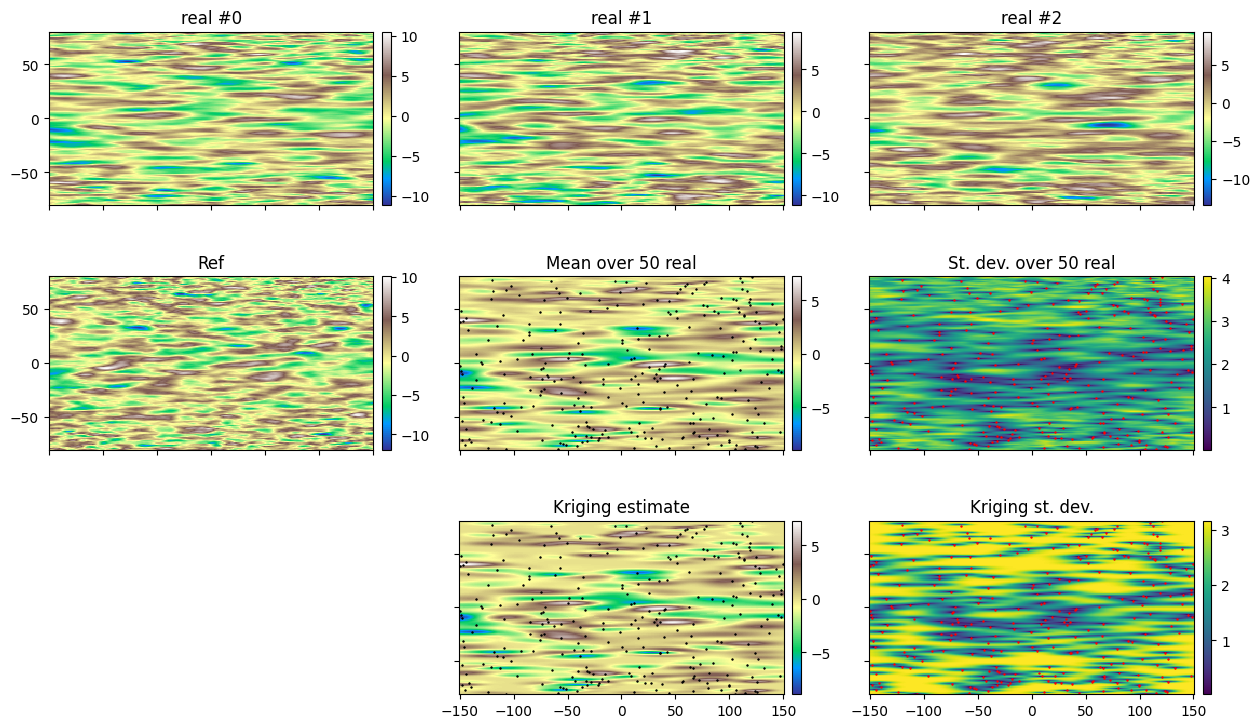

In [32]:
cmap = 'terrain'

# Plot
fig, ax = plt.subplots(3, 3, figsize=(15, 9), sharex=True, sharey=True)

# 3 first real ...
for i in (0, 1, 2):
    plt.subplot(3, 3, i+1)
    gn.imgplot.drawImage2D(simul, iv=i, cmap=cmap)
    #plt.plot(x[:,0],x[:,1], '+', c='black', markersize=10) # add conditioning point locations
    plt.title('real #{}'.format(i))

# ref 
plt.subplot(3, 3, 4)
gn.imgplot.drawImage2D(im_ref, cmap=cmap)
#plt.plot(x[:,0],x[:,1], '+', c='black', markersize=10) # add conditioning point locations
plt.title('Ref')

# mean of all real
plt.subplot(3, 3, 5)
gn.imgplot.drawImage2D(simul_mean, cmap=cmap)
plt.plot(x[:,0],x[:,1], '+', c='black', markersize=2) # add conditioning point locations
plt.title('Mean over {} real'.format(nreal))

# standard deviation of all real
plt.subplot(3, 3, 6)
gn.imgplot.drawImage2D(simul_std, cmap='viridis')
plt.plot(x[:,0],x[:,1], '+', c='red', markersize=2) # add conditioning point locations
plt.title('St. dev. over {} real'.format(nreal))

plt.subplot(3, 3, 7)
plt.axis('off')

# kriging estimate
plt.subplot(3, 3, 8)
gn.imgplot.drawImage2D(im_krig, iv=0, cmap=cmap)
plt.plot(x[:,0],x[:,1], '+', c='black', markersize=2) # add conditioning point locations
plt.title('Kriging estimate')

# kriging standard deviation
plt.subplot(3, 3, 9)
gn.imgplot.drawImage2D(im_krig, iv=1, cmap='viridis')
plt.plot(x[:,0],x[:,1], '+', c='red', markersize=2) # add conditioning point locations
plt.title('Kriging st. dev.')

plt.show()

## B2. Non-stationary range along 1st axis only

### Reference covariance model and non-stationarity
Define first a *stationary* anisotropic reference covariance model in 2D. Then, add the desired non-stationarity feature.

In [33]:
# Define a base covariance model (stationary)
cov_model_base = gn.covModel.CovModel2D(elem=[
    ('cubic', {'w':10, 'r':[30., 5.]}), # elementary contribution
    ], alpha=0.0, name='ref')

# Set list to handle non-stationarities
cov_model_non_stationarity_list = [
    ('multiply_r', im_r_factor.val[0], {'r_ind':0}), # multiply range by `im_r_factor.val[0]` along 1st main axis only, over the grid
]


### Do an unconditional simulation (reference)

simulate: Preprocessing data done: final number of data points : 0, inequality data points: 0
simulate: Computational resources: nproc = 1, nthreads_per_proc = 8, nproc_sgs_at_ineq = 8
simulate: (Step 1-3 skipped) No data
simulate: (Step 4) Do sgs (1 realizations) on the grid (at cell centers) using data points at cell centers...
simulate: Geos-Classic running on 1 process... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 8 thread(s)]
run_MPDSOMPGeosClassicSim: Geos-Classic running... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 8 thread(s)]
run_MPDSOMPGeosClassicSim: Geos-Classic run complete
simulate: Geos-Classic (1 process) run complete
simulate: warnings encountered (5 times in all):
#  1: WARNING 02001: a neigbhor has been dropped (solving kriging system)


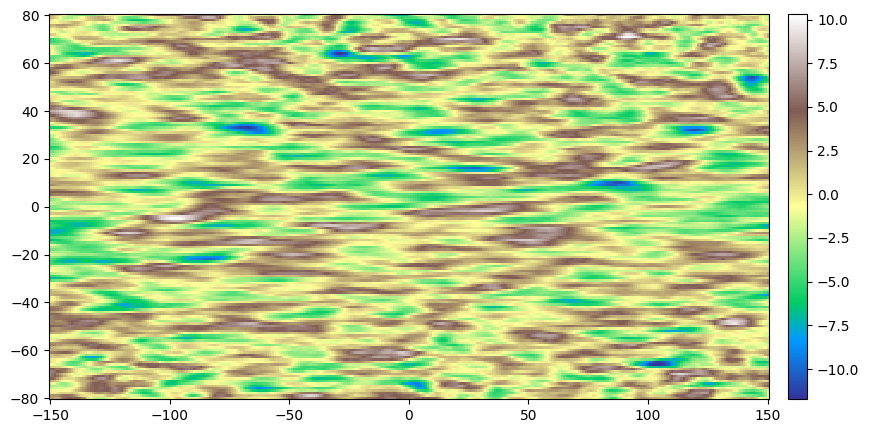

In [34]:
# Simulation
nreal = 1
np.random.seed(85)
geosclassic_output = gn.geosclassicinterface.simulate(
                        cov_model_base, (nx, ny), (sx, sy), (ox, oy),
                        method='simple_kriging', 
                        cov_model_non_stationarity_list=cov_model_non_stationarity_list,
                        nneighborMax=20, 
                        nreal=nreal, 
                        nproc=1, nthreads_per_proc=8)

im_ref = geosclassic_output['image']

plt.figure(figsize=(15,5))
gn.imgplot.drawImage2D(im_ref, cmap='terrain')
plt.show()

### Build a non-stationary data set (2D)

The data set is defined by extracting some points from the simulation of reference.

*Note:* the data set should contain enough points to catch the non-stationarities.

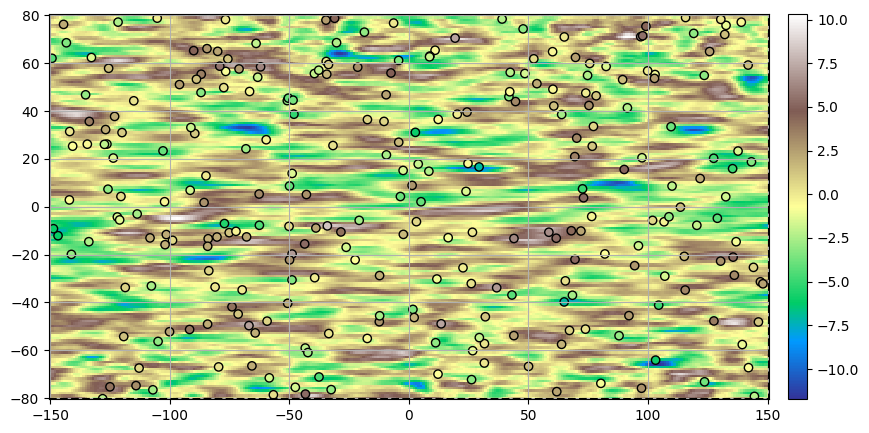

In [35]:
# Extract som points from the simulation
n = 280

# --- Choose 1. or 2. below ---
# # 1. Sampling the image
# ps = gn.img.sampleFromImage(im_ref, n, seed=234)
# # Data points and data value
# x = np.array((ps.x(), ps.y())).T
# v = ps.val[3]
# # Optionally: move points in the grid cells randomly, and add noise to values
# x[:, 0] = x[:, 0] + (np.random.random(n)-0.5)* im_ref.sx
# x[:, 1] = x[:, 1] + (np.random.random(n)-0.5)* im_ref.sy
# v = v + (np.random.random(n)-0.5)* 1.e-1

# 2. Using the function interpolating the image values
f = gn.img.Img_interp_func(im_ref, iz=0)
np.random.seed(864)
x1 = im_ref.xmin() + np.random.random(n) * (im_ref.xmax()-im_ref.xmin())
x2 = im_ref.ymin() + np.random.random(n) * (im_ref.ymax()-im_ref.ymin())
x = np.array((x1, x2)).T
v = f(x)
# ----- #

plt.figure(figsize=(15,5))
gn.imgplot.drawImage2D(im_ref, cmap='terrain')

plt.scatter(x[:,0], x[:,1], c=v, edgecolors='black', cmap='terrain', vmin=im_ref.vmin()[0], vmax=im_ref.vmax()[0])
plt.plot([xmin, xmax, xmax, xmin, xmin], [ymin, ymin, ymax, ymax, ymin], ls='dashed', c='black')
#plt.colorbar()
plt.axis('equal')
plt.grid()
plt.show()

### Simulation starting from a non-stationary data set in 2D and assuming "non-stationarity feature(s)" known

- `n`: number of data points
- `x`: location of data points (2-dimensional array of shape `(n, 2)`, each row is a point)
- `v`: values at data points (1-dimensional array of length `n`)
- `im_r_factor`: image of the factor (multiplier) `r_factor` in the grid; the function `r_factor_inv_loc_func` (interpolator of the inverse of `r_factor` in the grid) is built from this image

In [36]:
# Set a function interpolating the inverse of the r_factor (given location)
im_tmp = gn.img.copyImg(im_r_factor)
im_tmp.val = 1.0/im_tmp.val
r_factor_inv_loc_func = gn.img.Img_interp_func(im_tmp, ind=0, iz=0) 
# -> specify iz=0: consider only x and y coordinates in the layer iz=0

### Fitting covariance model accounting for non-stationarity

In [37]:
cov_model_to_optimize = gn.covModel.CovModel2D(elem=[
        ('cubic', {'w':np.nan, 'r':[np.nan, np.nan]}), # elementary contribution
         ], alpha=0.0, name='')

t1 = time.time()
cov_model_opt, popt = gn.covModel.covModel2D_fit(
                x, v, cov_model_to_optimize, 
                coord1_factor_loc_func=r_factor_inv_loc_func, 
                coord2_factor_loc_func=None, 
                         # deal with non-stationarity (multiplier for range along each axis)
                loc_m=1, # loc_m > 0: number of sub-intervals btw pair of points to estimate local function (default 1)
                         # loc_m = 0: take factor from one point
                bounds=([ 0,  0,  0],  # min value for param. to fit
                        [40, 80, 80]), # max value for param. to fit
                hmax=None, make_plot=False) # figure size for plot
t2 = time.time()
print(f'Fitting covariance model - elapsed time: {t2-t1:.4g} sec')

cov_model_opt

Fitting covariance model - elapsed time: 0.3194 sec


*** CovModel2D object ***
name = ''
number of elementary contribution(s): 1
elementary contribution 0
    type: cubic
    parameters:
        w = 8.67155636348228
        r = [np.float64(39.949605808465144), np.float64(6.07667278450453)]
angle: alpha = 0.0 deg.
    i.e.: the system Ox'y', supporting the axes of the model (ranges),
    is obtained from the system Oxy by applying a rotation of angle -alpha.
*****

#### Cross-validation by leave-one-out error

----- CRPS (negative; the larger, the better) -----
   mean = -1.633
   def. = -0.6861
----- 1) "Normal law test for mean of normalized error" -----
   p-value = 0.4672
   success = True (wrt significance level 0.05)
      (-> model has no reason to be rejected)
----- 2) "Chi-square test for sum of squares of normalized error" -----
   p-value = 4.94e-12
   success = False (wrt significance level 0.05)
      -> model should be REJECTED
----- Statistics of normalized error -----
   mean     = 0.04345 (should be close to 0)
   std      = 1.298 (should be close to 1)
   skewness = -0.1399 (should be close to 0)
   excess kurtosis = 5.386 (should be close to 0)


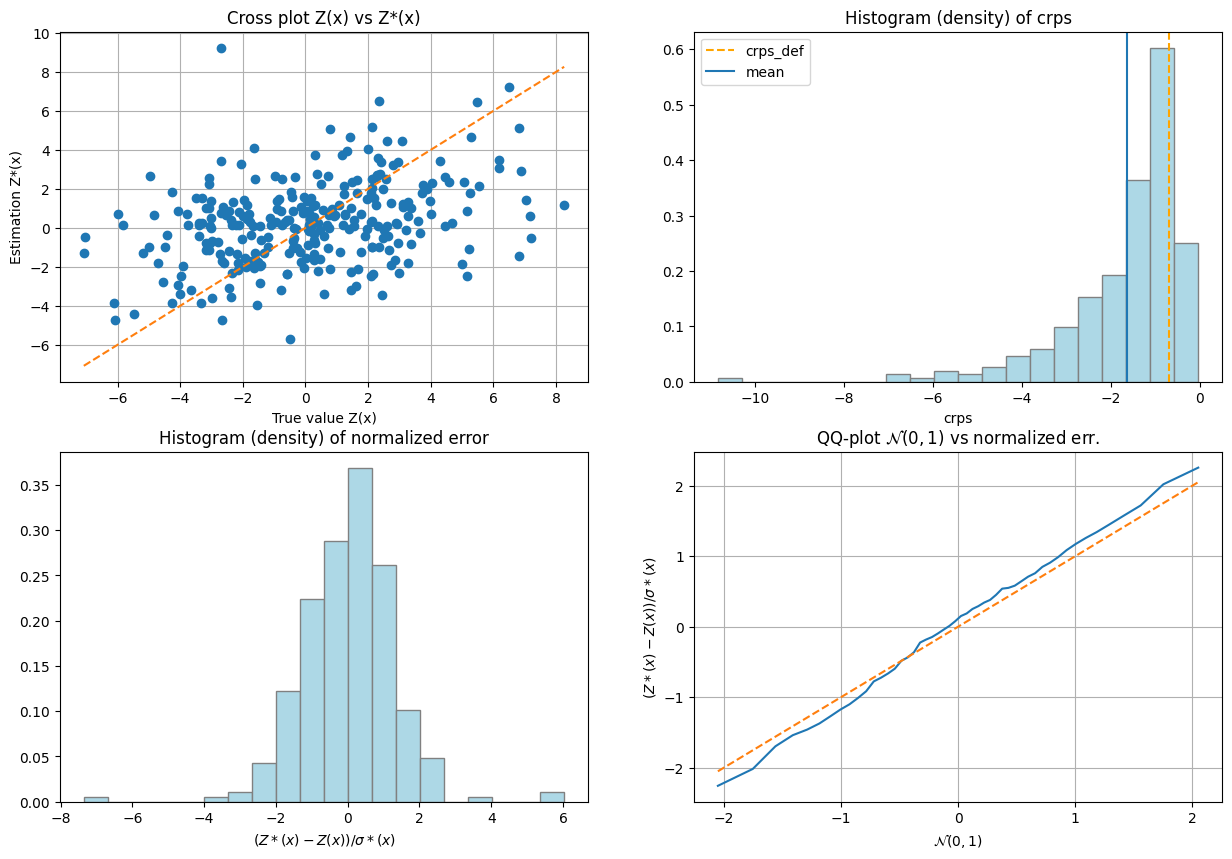

In [38]:
# Set a function interpolating the r_factor (given location)
r_factor_loc_func = gn.img.Img_interp_func(im_r_factor, ind=0, iz=0) 
# -> specify iz=0: consider only x and y coordinates in the layer iz=0

# Set list to handle non-stationarities at x
cov_model_non_stationarity_x_list = [
    ('multiply_r', r_factor_loc_func(x))
]

# Interpolation by simple kriging
cv_est1, cv_std1, crps1, crps_def1, pvalue1, success1 = gn.covModel.cross_valid_loo(
                                        x, v, cov_model_opt,
                                        interpolator=gn.covModel.krige, 
                                        interpolator_kwargs={'method':'ordinary_kriging'},
                                        cov_model_non_stationarity_x_list=cov_model_non_stationarity_x_list,
                                        print_result=True, make_plot=True, figsize=(15,10), nbins=20)
plt.show()

### Show experimental variogram, fitted model and reference model

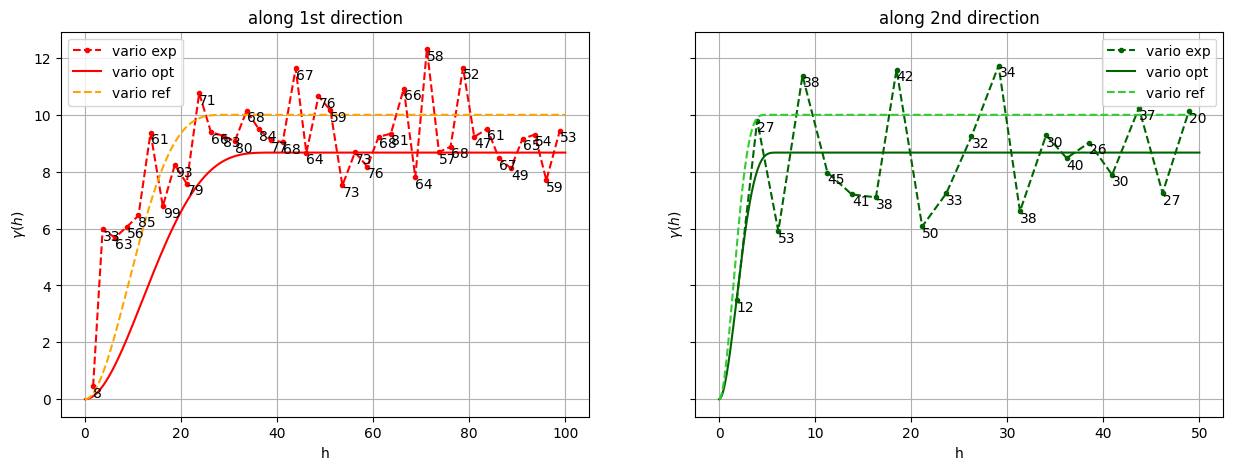

In [39]:
hmax1, hmax2 = 100.0, 50.0

(hexp1, gexp1, cexp1), (hexp2, gexp2, cexp2) = gn.covModel.variogramExp2D(
                x, v, alpha=0, hmax=(hmax1, hmax2), 
                coord1_factor_loc_func=r_factor_inv_loc_func, coord2_factor_loc_func=None, loc_m=1,
                ncla=(40, 20), make_plot=False)

plt.subplots(1,2, sharey=True, figsize=(15,5))
plt.subplot(1,2,1)
gn.covModel.plot_variogramExp1D(hexp1, gexp1, cexp1, c='red', label='vario exp')
cov_model_opt.plot_model_one_curve(vario=True, main_axis=1, hmax=hmax1, c='red', label='vario opt')
cov_model_base.plot_model_one_curve(vario=True, main_axis=1, hmax=hmax1, c='orange', ls='dashed', label='vario ref')
plt.legend()
plt.title("along 1st direction")

plt.subplot(1,2,2)
gn.covModel.plot_variogramExp1D(hexp2, gexp2, cexp2, c='darkgreen', label='vario exp')
cov_model_opt.plot_model_one_curve(vario=True, main_axis=2, hmax=hmax2, c='darkgreen', label='vario opt')
cov_model_base.plot_model_one_curve(vario=True, main_axis=2, hmax=hmax2, c='limegreen', ls='dashed', label='vario ref')
plt.legend()
plt.title("along 2nd direction")

plt.show()

### Kriging and conditional simulations

In [40]:
# Kriging
t1 = time.time() # start time
geosclassic_output = gn.geosclassicinterface.estimate(
                        cov_model_opt, (nx, ny), (sx, sy), (ox, oy), 
                        x=x, v=v, 
                        method='simple_kriging', 
                        cov_model_non_stationarity_list=cov_model_non_stationarity_list,
                        nneighborMax=20,
                        nthreads=8)
t2 = time.time() # end time
print(f'Kriging - elapsed time: {t2-t1:.4g} sec')

# Retrieve kriging estimate and standard deviation
im_krig = geosclassic_output['image']

estimate: Preprocessing data done: final number of data points : 279, inequality data points: 0
estimate: Computational resources: nthreads = 8, nproc_sgs_at_ineq = 8
estimate: (Step 1) No inequality data
estimate: (Step 2) Set new dataset gathering data and inequality data locations...
estimate: (Step 3) Do kriging at the center of grid cells containing at least one data point...
estimate: (Step 4) Do kriging on the grid (at cell centers) using data points at cell centers...
estimate: Geos-Classic running on 1 process... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 8 thread(s)]
run_MPDSOMPGeosClassicSim: Geos-Classic running... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 8 thread(s)]
run_MPDSOMPGeosClassicSim: Geos-Classic run complete
estimate: Geos-Classic (1 process) run complete
estimate: warnings encountered (779 times in all):
#  1: WARNING 02001: a neigbhor has been dropped (solving kriging system)
#  2: WARNING 02015: solving kriging system fails (do as if no neighbor)
Krig

In [41]:
# Simulation
nreal = 50
np.random.seed(22131)
t1 = time.time() # start time
geosclassic_output = gn.geosclassicinterface.simulate(
                        cov_model_opt, (nx, ny), (sx, sy), (ox, oy), 
                        x=x, v=v, 
                        method='simple_kriging', 
                        cov_model_non_stationarity_list=cov_model_non_stationarity_list,
                        nneighborMax=20,
                        nreal=nreal,
                        nproc=2, nthreads_per_proc=4)
t2 = time.time() # end time
print(f'{nreal} simul. - elapsed time: {t2-t1:.4g} sec')

# Retrieve the realizations
simul = geosclassic_output['image']

# Compute mean and standard deviation (pixel-wise)
simul_mean = gn.img.imageContStat(simul, op='mean')
simul_std = gn.img.imageContStat(simul, op='std')

simulate: Preprocessing data done: final number of data points : 279, inequality data points: 0
simulate: Computational resources: nproc = 2, nthreads_per_proc = 4, nproc_sgs_at_ineq = 8
simulate: (Step 1) No inequality data
simulate: (Step 2) Set new dataset gathering data and inequality data locations...
simulate: (Step 3) Do kriging at the center of grid cells containing at least one data point...
simulate: (Step 4) Do sgs (50 realizations) on the grid (at cell centers) using data points at cell centers...
simulate: Geos-Classic running on 2 process(es)... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 4 thread(s)]
run_MPDSOMPGeosClassicSim [pid=0]: Geos-Classic running... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 4 thread(s)]
run_MPDSOMPGeosClassicSim [pid=0]: Geos-Classic run complete
simulate: Geos-Classic (2 process(es)) run complete
simulate: warnings encountered (124 times in all):
#  1: WARNING 02001: a neigbhor has been dropped (solving kriging system)
#  2: WARNING 02015

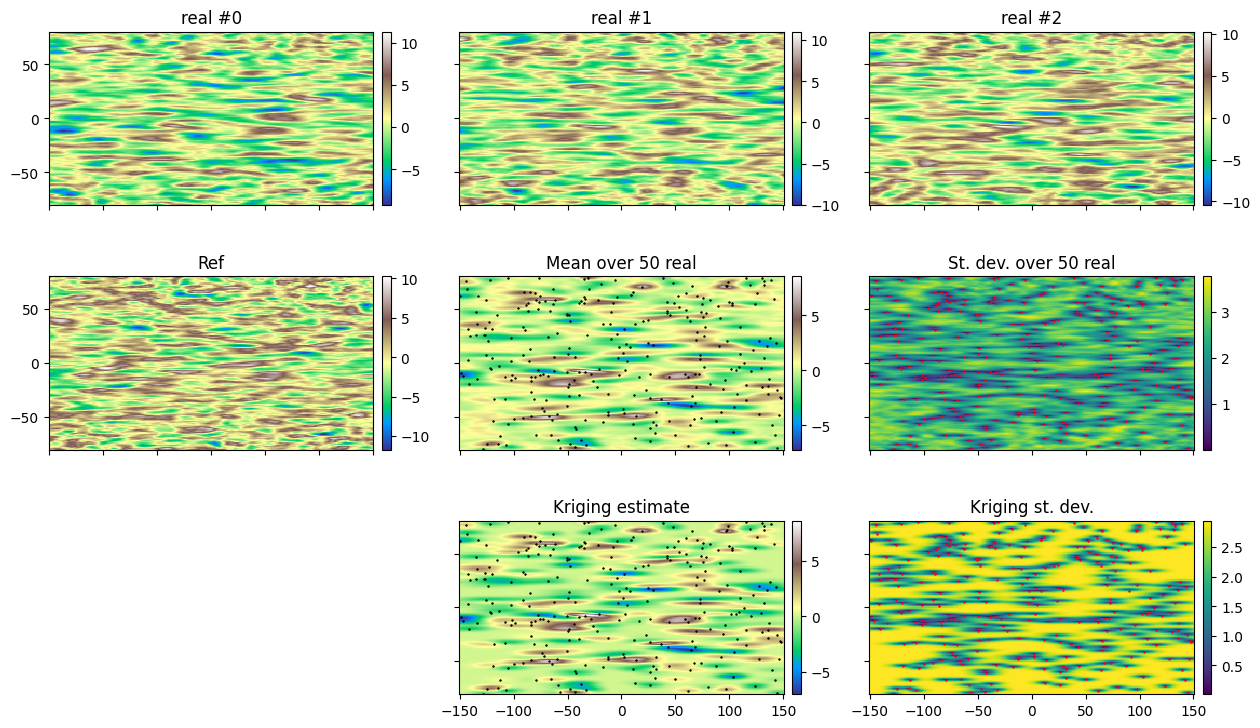

In [42]:
cmap = 'terrain'

# Plot
fig, ax = plt.subplots(3, 3, figsize=(15, 9), sharex=True, sharey=True)

# 3 first real ...
for i in (0, 1, 2):
    plt.subplot(3, 3, i+1)
    gn.imgplot.drawImage2D(simul, iv=i, cmap=cmap)
    #plt.plot(x[:,0],x[:,1], '+', c='black', markersize=10) # add conditioning point locations
    plt.title('real #{}'.format(i))

# ref 
plt.subplot(3, 3, 4)
gn.imgplot.drawImage2D(im_ref, cmap=cmap)
#plt.plot(x[:,0],x[:,1], '+', c='black', markersize=10) # add conditioning point locations
plt.title('Ref')

# mean of all real
plt.subplot(3, 3, 5)
gn.imgplot.drawImage2D(simul_mean, cmap=cmap)
plt.plot(x[:,0],x[:,1], '+', c='black', markersize=2) # add conditioning point locations
plt.title('Mean over {} real'.format(nreal))

# standard deviation of all real
plt.subplot(3, 3, 6)
gn.imgplot.drawImage2D(simul_std, cmap='viridis')
plt.plot(x[:,0],x[:,1], '+', c='red', markersize=2) # add conditioning point locations
plt.title('St. dev. over {} real'.format(nreal))

plt.subplot(3, 3, 7)
plt.axis('off')

# kriging estimate
plt.subplot(3, 3, 8)
gn.imgplot.drawImage2D(im_krig, iv=0, cmap=cmap)
plt.plot(x[:,0],x[:,1], '+', c='black', markersize=2) # add conditioning point locations
plt.title('Kriging estimate')

# kriging standard deviation
plt.subplot(3, 3, 9)
gn.imgplot.drawImage2D(im_krig, iv=1, cmap='viridis')
plt.plot(x[:,0],x[:,1], '+', c='red', markersize=2) # add conditioning point locations
plt.title('Kriging st. dev.')

plt.show()

## C. Non-stationary variance (sill)

### Reference covariance model and non-stationarity
Define first a *stationary* anisotropic reference covariance model in 2D. Then, add the desired non-stationarity feature.

In [43]:
# Define a base covariance model (stationary)
cov_model_base = gn.covModel.CovModel2D(elem=[
    ('cubic', {'w':10, 'r':[30., 5.]}), # elementary contribution
    ], alpha=0.0, name='ref')

# Set list to handle non-stationarities
cov_model_non_stationarity_list = [
    ('multiply_w', im_w_factor.val[0]), # multiply weight by `im_w_factor.val[0]` over the grid
]


### Do an unconditional simulation (reference)

simulate: Preprocessing data done: final number of data points : 0, inequality data points: 0
simulate: Computational resources: nproc = 1, nthreads_per_proc = 8, nproc_sgs_at_ineq = 8
simulate: (Step 1-3 skipped) No data
simulate: (Step 4) Do sgs (1 realizations) on the grid (at cell centers) using data points at cell centers...
simulate: Geos-Classic running on 1 process... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 8 thread(s)]
run_MPDSOMPGeosClassicSim: Geos-Classic running... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 8 thread(s)]
run_MPDSOMPGeosClassicSim: Geos-Classic run complete
simulate: Geos-Classic (1 process) run complete


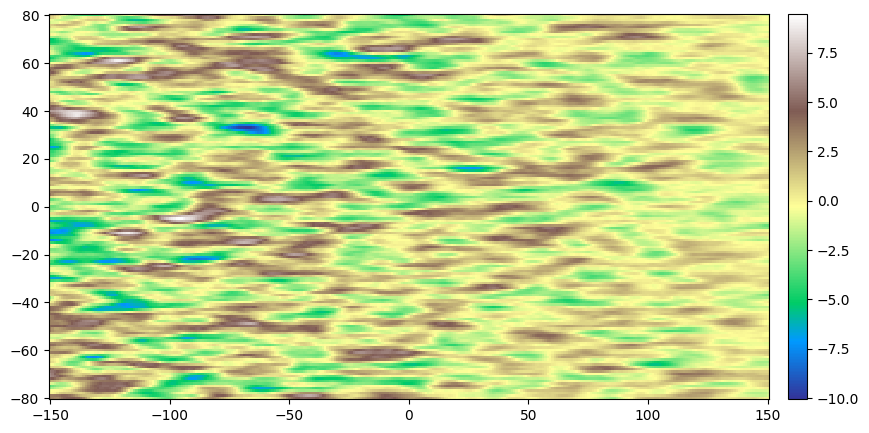

In [44]:
# Simulation
nreal = 1
np.random.seed(85)
geosclassic_output = gn.geosclassicinterface.simulate(
                        cov_model_base, (nx, ny), (sx, sy), (ox, oy),
                        method='simple_kriging', 
                        cov_model_non_stationarity_list=cov_model_non_stationarity_list,
                        nneighborMax=20, 
                        nreal=nreal, 
                        nproc=1, nthreads_per_proc=8)

im_ref = geosclassic_output['image']

plt.figure(figsize=(15,5))
gn.imgplot.drawImage2D(im_ref, cmap='terrain')
plt.show()

### Build a non-stationary data set (2D)

The data set is defined by extracting some points from the simulation of reference.

*Note:* the data set should contain enough points to catch the non-stationarities.

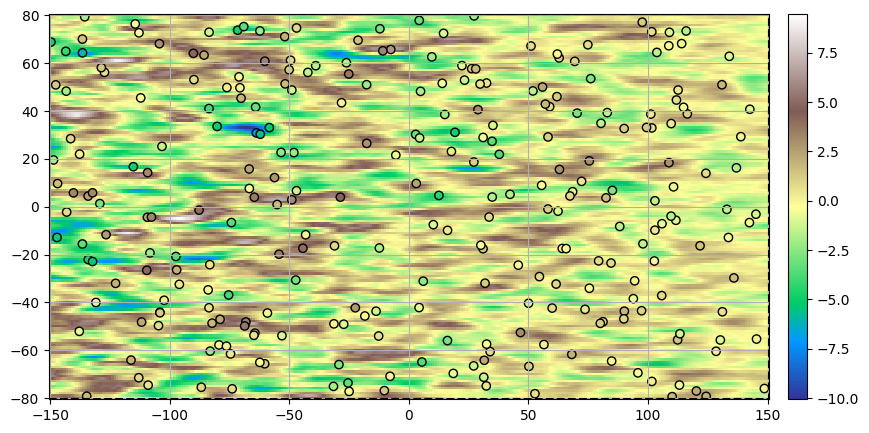

In [45]:
# Extract som points from the simulation
n = 280

# --- Choose 1. or 2. below ---
# # 1. Sampling the image
# ps = gn.img.sampleFromImage(im_ref, n, seed=234)
# # Data points and data value
# x = np.array((ps.x(), ps.y())).T
# v = ps.val[3]
# # Optionally: move points in the grid cells randomly, and add noise to values
# x[:, 0] = x[:, 0] + (np.random.random(n)-0.5)* im_ref.sx
# x[:, 1] = x[:, 1] + (np.random.random(n)-0.5)* im_ref.sy
# v = v + (np.random.random(n)-0.5)* 1.e-1

# 2. Using the function interpolating the image values
f = gn.img.Img_interp_func(im_ref, iz=0)
np.random.seed(9826)
x1 = im_ref.xmin() + np.random.random(n) * (im_ref.xmax()-im_ref.xmin())
x2 = im_ref.ymin() + np.random.random(n) * (im_ref.ymax()-im_ref.ymin())
x = np.array((x1, x2)).T
v = f(x)
# ----- #

plt.figure(figsize=(15,5))
gn.imgplot.drawImage2D(im_ref, cmap='terrain')

plt.scatter(x[:,0], x[:,1], c=v, edgecolors='black', cmap='terrain', vmin=im_ref.vmin()[0], vmax=im_ref.vmax()[0])
plt.plot([xmin, xmax, xmax, xmin, xmin], [ymin, ymin, ymax, ymax, ymin], ls='dashed', c='black')
#plt.colorbar()
plt.axis('equal')
plt.grid()
plt.show()

### Simulation starting from a non-stationary data set in 2D and assuming "non-stationarity feature(s)" known

- `n`: number of data points
- `x`: location of data points (2-dimensional array of shape `(n, 2)`, each row is a point)
- `v`: values at data points (1-dimensional array of length `n`)
- `im_w_factor`: image of the factor (multiplier) `w_factor` in the grid; the function `w_factor_inv_loc_func` (interpolator of the inverse of `w_factor` in the grid) is built from this image

In [46]:
# Set a function interpolating the inverse of the w_factor (given location)
im_tmp = gn.img.copyImg(im_w_factor)
im_tmp.val = 1.0/im_tmp.val
w_factor_inv_loc_func = gn.img.Img_interp_func(im_tmp, ind=0, iz=0)
# -> specify iz=0: consider only x and y coordinates in the layer iz=0

### Fitting covariance model accounting for non-stationarity

In [47]:
cov_model_to_optimize = gn.covModel.CovModel2D(elem=[
        ('cubic', {'w':np.nan, 'r':[np.nan, np.nan]}), # elementary contribution
         ], alpha=0.0, name='')

t1 = time.time()
cov_model_opt, popt = gn.covModel.covModel2D_fit(
                x, v, cov_model_to_optimize, 
                w_factor_loc_func=w_factor_inv_loc_func, # deal with non-stationarity (multiplier for weight)
                loc_m=1, # loc_m > 0: number of sub-intervals btw pair of points to estimate local function (default 1)
                         # loc_m = 0: take factor from one point
                bounds=([ 0,  0,  0],  # min value for param. to fit
                        [40, 80, 80]), # max value for param. to fit
                hmax=None, make_plot=False) # figure size for plot
t2 = time.time()
print(f'Fitting covariance model - elapsed time: {t2-t1:.4g} sec')

cov_model_opt

Fitting covariance model - elapsed time: 0.2983 sec


*** CovModel2D object ***
name = ''
number of elementary contribution(s): 1
elementary contribution 0
    type: cubic
    parameters:
        w = 10.576581439758836
        r = [np.float64(66.69782468331191), np.float64(15.947504702500291)]
angle: alpha = 0.0 deg.
    i.e.: the system Ox'y', supporting the axes of the model (ranges),
    is obtained from the system Oxy by applying a rotation of angle -alpha.
*****

#### Cross-validation by leave-one-out error

----- CRPS (negative; the larger, the better) -----
   mean = -1.505
   def. = -0.5231
----- 1) "Normal law test for mean of normalized error" -----
   p-value = 0.8159
   success = True (wrt significance level 0.05)
      (-> model has no reason to be rejected)
----- 2) "Chi-square test for sum of squares of normalized error" -----
   p-value = 0
   success = False (wrt significance level 0.05)
      -> model should be REJECTED
----- Statistics of normalized error -----
   mean     = 0.01391 (should be close to 0)
   std      = 2.765 (should be close to 1)
   skewness = 0.0292 (should be close to 0)
   excess kurtosis = 0.3862 (should be close to 0)


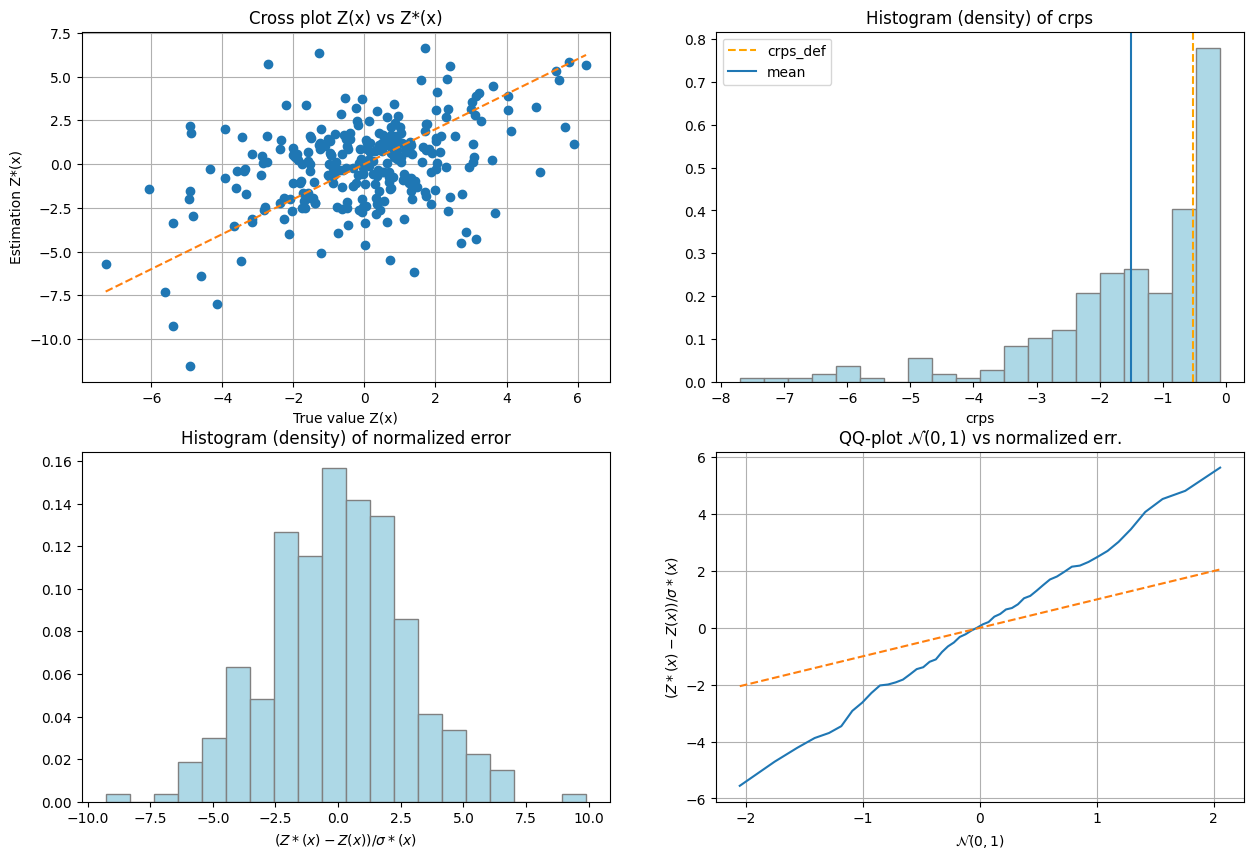

In [48]:
# Set a function interpolating the r_factor (given location)
w_factor_loc_func = gn.img.Img_interp_func(im_w_factor, ind=0, iz=0) 
# -> specify iz=0: consider only x and y coordinates in the layer iz=0

# Set list to handle non-stationarities at x
cov_model_non_stationarity_x_list = [
    ('multiply_w', w_factor_loc_func(x))
]

# Interpolation by simple kriging
cv_est1, cv_std1, crps1, crps_def1, pvalue1, success1 = gn.covModel.cross_valid_loo(
                                        x, v, cov_model_opt,
                                        interpolator=gn.covModel.krige, 
                                        interpolator_kwargs={'method':'ordinary_kriging'},
                                        cov_model_non_stationarity_x_list=cov_model_non_stationarity_x_list,
                                        print_result=True, make_plot=True, figsize=(15,10), nbins=20)
plt.show()

### Show experimental variogram, fitted model and reference model

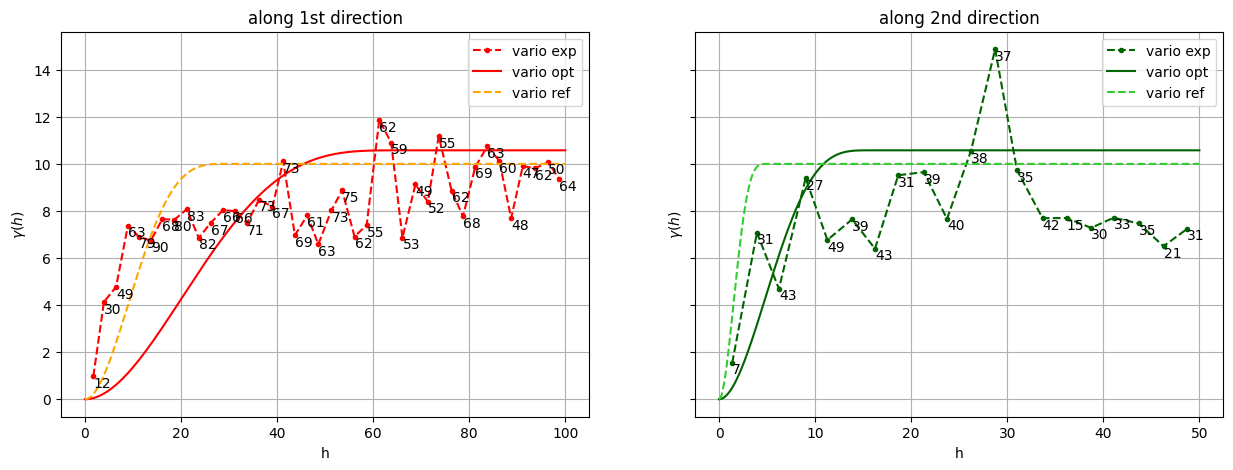

In [49]:
hmax1, hmax2 = 100.0, 50.0

(hexp1, gexp1, cexp1), (hexp2, gexp2, cexp2) = gn.covModel.variogramExp2D(
                x, v, alpha=0, hmax=(hmax1, hmax2), 
                w_factor_loc_func=w_factor_inv_loc_func, loc_m=1,
                ncla=(40, 20), make_plot=False)

plt.subplots(1,2, sharey=True, figsize=(15,5))
plt.subplot(1,2,1)
gn.covModel.plot_variogramExp1D(hexp1, gexp1, cexp1, c='red', label='vario exp')
cov_model_opt.plot_model_one_curve(vario=True, main_axis=1, hmax=hmax1, c='red', label='vario opt')
cov_model_base.plot_model_one_curve(vario=True, main_axis=1, hmax=hmax1, c='orange', ls='dashed', label='vario ref')
plt.legend()
plt.title("along 1st direction")

plt.subplot(1,2,2)
gn.covModel.plot_variogramExp1D(hexp2, gexp2, cexp2, c='darkgreen', label='vario exp')
cov_model_opt.plot_model_one_curve(vario=True, main_axis=2, hmax=hmax2, c='darkgreen', label='vario opt')
cov_model_base.plot_model_one_curve(vario=True, main_axis=2, hmax=hmax2, c='limegreen', ls='dashed', label='vario ref')
plt.legend()
plt.title("along 2nd direction")

plt.show()

### Kriging and conditional simulations

In [50]:
# Kriging
t1 = time.time() # start time
geosclassic_output = gn.geosclassicinterface.estimate(
                        cov_model_opt, (nx, ny), (sx, sy), (ox, oy), 
                        x=x, v=v, 
                        method='simple_kriging', 
                        cov_model_non_stationarity_list=cov_model_non_stationarity_list,
                        nneighborMax=20,
                        nthreads=8)
t2 = time.time() # end time
print(f'Kriging - elapsed time: {t2-t1:.4g} sec')

# Retrieve kriging estimate and standard deviation
im_krig = geosclassic_output['image']

estimate: Preprocessing data done: final number of data points : 279, inequality data points: 0
estimate: Computational resources: nthreads = 8, nproc_sgs_at_ineq = 8
estimate: (Step 1) No inequality data
estimate: (Step 2) Set new dataset gathering data and inequality data locations...
estimate: (Step 3) Do kriging at the center of grid cells containing at least one data point...
estimate: (Step 4) Do kriging on the grid (at cell centers) using data points at cell centers...
estimate: Geos-Classic running on 1 process... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 8 thread(s)]
run_MPDSOMPGeosClassicSim: Geos-Classic running... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 8 thread(s)]
run_MPDSOMPGeosClassicSim: Geos-Classic run complete
estimate: Geos-Classic (1 process) run complete
Kriging - elapsed time: 0.3253 sec


In [51]:
# Simulation
nreal = 50
np.random.seed(22131)
t1 = time.time() # start time
geosclassic_output = gn.geosclassicinterface.simulate(
                        cov_model_opt, (nx, ny), (sx, sy), (ox, oy), 
                        x=x, v=v, 
                        method='simple_kriging', 
                        cov_model_non_stationarity_list=cov_model_non_stationarity_list,
                        nneighborMax=20,
                        nreal=nreal,
                        nproc=2, nthreads_per_proc=4)
t2 = time.time() # end time
print(f'{nreal} simul. - elapsed time: {t2-t1:.4g} sec')

# Retrieve the realizations
simul = geosclassic_output['image']

# Compute mean and standard deviation (pixel-wise)
simul_mean = gn.img.imageContStat(simul, op='mean')
simul_std = gn.img.imageContStat(simul, op='std')

simulate: Preprocessing data done: final number of data points : 279, inequality data points: 0
simulate: Computational resources: nproc = 2, nthreads_per_proc = 4, nproc_sgs_at_ineq = 8
simulate: (Step 1) No inequality data
simulate: (Step 2) Set new dataset gathering data and inequality data locations...
simulate: (Step 3) Do kriging at the center of grid cells containing at least one data point...
simulate: (Step 4) Do sgs (50 realizations) on the grid (at cell centers) using data points at cell centers...
simulate: Geos-Classic running on 2 process(es)... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 4 thread(s)]
run_MPDSOMPGeosClassicSim [pid=0]: Geos-Classic running... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 4 thread(s)]
run_MPDSOMPGeosClassicSim [pid=0]: Geos-Classic run complete
simulate: Geos-Classic (2 process(es)) run complete
50 simul. - elapsed time: 6.248 sec


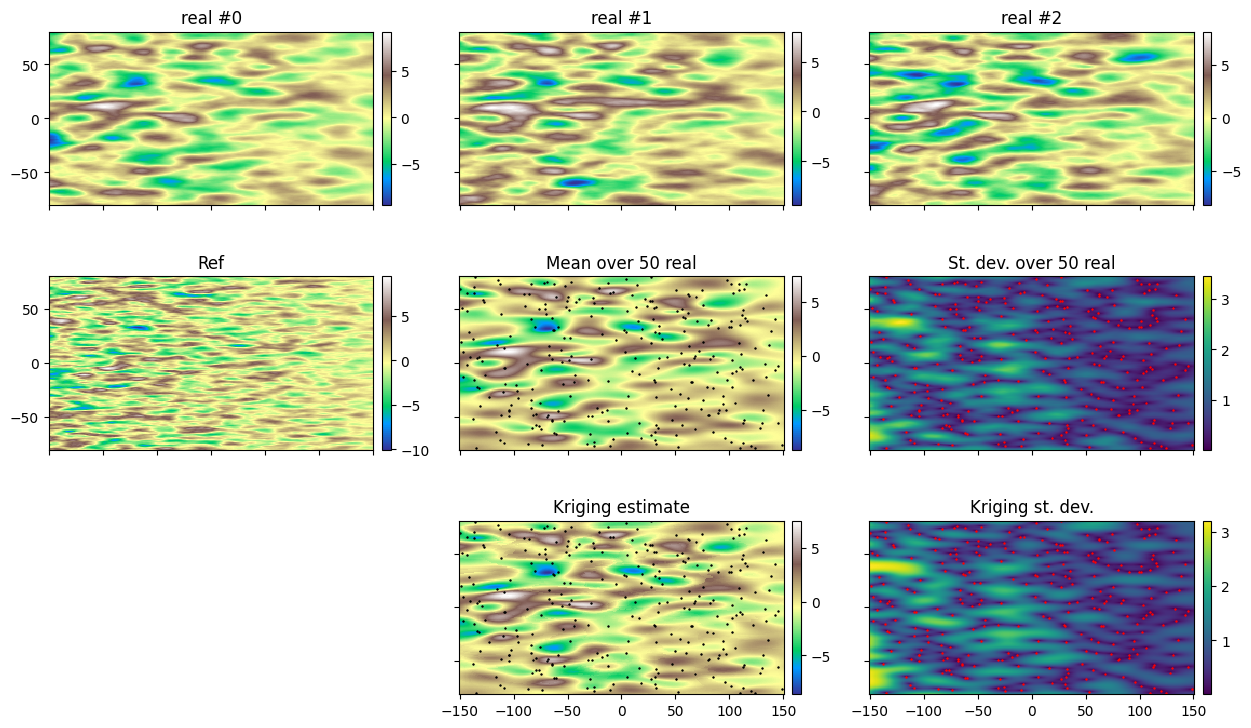

In [52]:
cmap = 'terrain'

# Plot
fig, ax = plt.subplots(3, 3, figsize=(15, 9), sharex=True, sharey=True)

# 3 first real ...
for i in (0, 1, 2):
    plt.subplot(3, 3, i+1)
    gn.imgplot.drawImage2D(simul, iv=i, cmap=cmap)
    #plt.plot(x[:,0],x[:,1], '+', c='black', markersize=10) # add conditioning point locations
    plt.title('real #{}'.format(i))

# ref 
plt.subplot(3, 3, 4)
gn.imgplot.drawImage2D(im_ref, cmap=cmap)
#plt.plot(x[:,0],x[:,1], '+', c='black', markersize=10) # add conditioning point locations
plt.title('Ref')

# mean of all real
plt.subplot(3, 3, 5)
gn.imgplot.drawImage2D(simul_mean, cmap=cmap)
plt.plot(x[:,0],x[:,1], '+', c='black', markersize=2) # add conditioning point locations
plt.title('Mean over {} real'.format(nreal))

# standard deviation of all real
plt.subplot(3, 3, 6)
gn.imgplot.drawImage2D(simul_std, cmap='viridis')
plt.plot(x[:,0],x[:,1], '+', c='red', markersize=2) # add conditioning point locations
plt.title('St. dev. over {} real'.format(nreal))

plt.subplot(3, 3, 7)
plt.axis('off')

# kriging estimate
plt.subplot(3, 3, 8)
gn.imgplot.drawImage2D(im_krig, iv=0, cmap=cmap)
plt.plot(x[:,0],x[:,1], '+', c='black', markersize=2) # add conditioning point locations
plt.title('Kriging estimate')

# kriging standard deviation
plt.subplot(3, 3, 9)
gn.imgplot.drawImage2D(im_krig, iv=1, cmap='viridis')
plt.plot(x[:,0],x[:,1], '+', c='red', markersize=2) # add conditioning point locations
plt.title('Kriging st. dev.')

plt.show()

## D. Non-stationary for orientation, ranges and variance (sill)

Note that the ranges are expressed in local axes, which are locally varying when non-stationary orientation is specified.

### Reference covariance model and non-stationarity
Define first a *stationary* anisotropic reference covariance model in 2D. Then, add the desired non-stationarity feature.

In [53]:
# Define a base covariance model (stationary)
cov_model_base = gn.covModel.CovModel2D(elem=[
    ('cubic', {'w':10, 'r':[30., 5.]}), # elementary contribution
    ], alpha=0.0, name='ref')

# Local roation
# -------------
# Define the functions `alpha_loc_func`, (resp. `alpha_loc_func_xy`) and that returns the angle(s) 
# alpha at given location(s) from one parameter: point(s) in 2D (resp. two parameters: x, y coordinate(s))
alpha_loc_func = gn.img.Img_interp_func(im_alpha, ind=0, iz=0, angle_var=True)
    # Specify iz=0: consider only x, and y coordinates in the layer iz=0

def alpha_loc_func_xy(x, y):
    x = np.atleast_1d(x)
    y = np.atleast_1d(y)
    return alpha_loc_func(np.vstack((x.reshape(-1), y.reshape(-1))).T).reshape(x.shape)


# Set list to handle other non-stationarities
cov_model_non_stationarity_list = [
    ('multiply_r', im_r_factor.val[0]), # multiply range by `im_r_factor.val[0]` over the grid
    ('multiply_w', im_w_factor.val[0]), # multiply weight by `im_w_factor.val[0]` over the grid
]


### Do an unconditional simulation (reference)

simulate: Preprocessing data done: final number of data points : 0, inequality data points: 0
simulate: Computational resources: nproc = 1, nthreads_per_proc = 8, nproc_sgs_at_ineq = 8
simulate: (Step 1-3 skipped) No data
simulate: (Step 4) Do sgs (1 realizations) on the grid (at cell centers) using data points at cell centers...
simulate: Geos-Classic running on 1 process... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 8 thread(s)]
run_MPDSOMPGeosClassicSim: Geos-Classic running... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 8 thread(s)]
run_MPDSOMPGeosClassicSim: Geos-Classic run complete
simulate: Geos-Classic (1 process) run complete
simulate: warnings encountered (51 times in all):
#  1: WARNING 02001: a neigbhor has been dropped (solving kriging system)


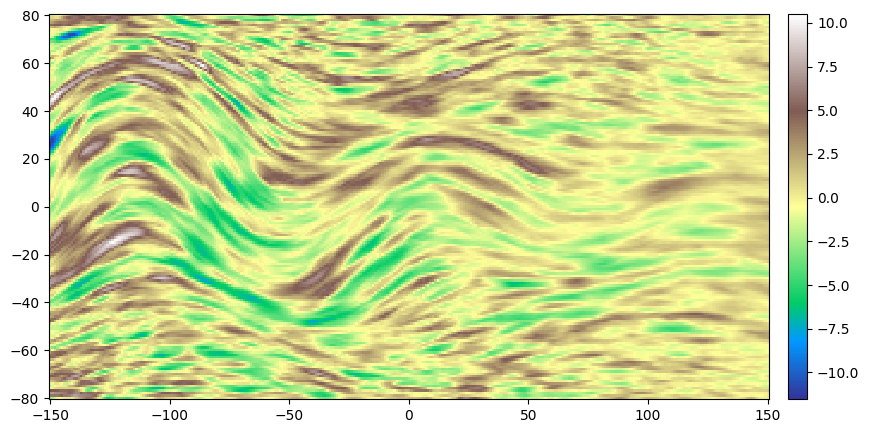

In [54]:
# Simulation
nreal = 1
np.random.seed(2332)
geosclassic_output = gn.geosclassicinterface.simulate(
                        cov_model_base, (nx, ny), (sx, sy), (ox, oy), 
                        method='simple_kriging', 
                        alpha=alpha_loc_func_xy,
                        cov_model_non_stationarity_list=cov_model_non_stationarity_list,
                        nneighborMax=20, nreal=nreal, 
                        nproc=1, nthreads_per_proc=8)

im_ref = geosclassic_output['image']

plt.figure(figsize=(15,5))
gn.imgplot.drawImage2D(im_ref, cmap='terrain')
plt.show()

### Build a non-stationary data set (2D)

The data set is defined by extracting some points from the simulation of reference.

*Note:* the data set should contain enough points to catch the non-stationarities.

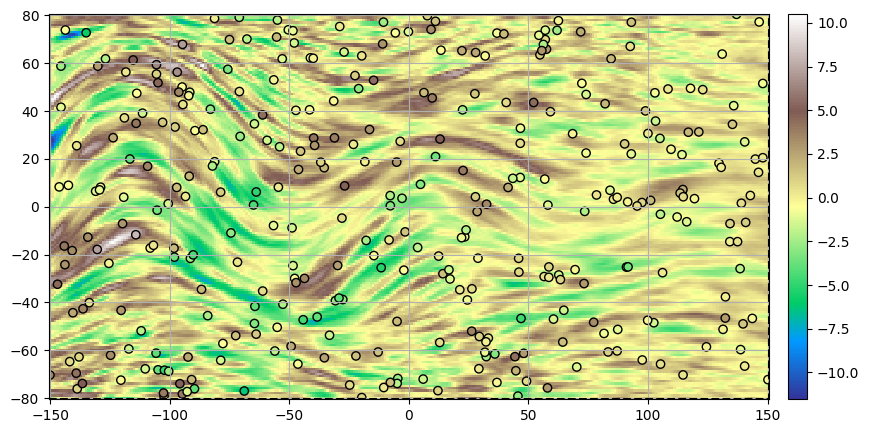

In [55]:
# Extract som points from the simulation
n = 350

# --- Choose 1. or 2. below ---
# # 1. Sampling the image
# ps = gn.img.sampleFromImage(im_ref, n, seed=234)
# # Data points and data value
# x = np.array((ps.x(), ps.y())).T
# v = ps.val[3]
# # Optionally: move points in the grid cells randomly, and add noise to values
# x[:, 0] = x[:, 0] + (np.random.random(n)-0.5)* im_ref.sx
# x[:, 1] = x[:, 1] + (np.random.random(n)-0.5)* im_ref.sy
# v = v + (np.random.random(n)-0.5)* 1.e-1

# 2. Using the function interpolating the image values
f = gn.img.Img_interp_func(im_ref, iz=0)
np.random.seed(4428)
x1 = im_ref.xmin() + np.random.random(n) * (im_ref.xmax()-im_ref.xmin())
x2 = im_ref.ymin() + np.random.random(n) * (im_ref.ymax()-im_ref.ymin())
x = np.array((x1, x2)).T
v = f(x)
# ----- #

plt.figure(figsize=(15,5))
gn.imgplot.drawImage2D(im_ref, cmap='terrain')

plt.scatter(x[:,0], x[:,1], c=v, edgecolors='black', cmap='terrain', vmin=im_ref.vmin()[0], vmax=im_ref.vmax()[0])
plt.plot([xmin, xmax, xmax, xmin, xmin], [ymin, ymin, ymax, ymax, ymin], ls='dashed', c='black')
#plt.colorbar()
plt.axis('equal')
plt.grid()
plt.show()

### Simulation starting from a non-stationary data set in 2D and assuming "non-stationarity feature(s)" known

- `n`: number of data points
- `x`: location of data points (2-dimensional array of shape `(n, 2)`, each row is a point)
- `v`: values at data points (1-dimensional array of length `n`)
- `im_alpha`: image of the angle `alpha` in the grid; the function `alpha_loc_func` (resp. `alpha_loc_func_xy`) which is an interpolator of `alpha` in the grid taking one parameter, points in 2D (resp. two parameters, the x and y coordinates of points in 2D)
- `im_r_factor`: image of the factor (multiplier) `r_factor` in the grid; the function `r_factor_inv_loc_func` (interpolator of the inverse of `r_factor` in the grid) is built from this image
- `im_w_factor`: image of the factor (multiplier) `w_factor` in the grid; the function `w_factor_inv_loc_func` (interpolator of the inverse of `w_factor` in the grid) is built from this image

In [56]:
# Set a function interpolating the inverse of the r_factor (given location)
im_tmp = gn.img.copyImg(im_r_factor)
im_tmp.val = 1.0/im_tmp.val
r_factor_inv_loc_func = gn.img.Img_interp_func(im_tmp, ind=0, iz=0) # Specify iz=0: consider only x, and y coordinates in the layer iz=0

# Set a function interpolating the inverse of the w_factor (given location)
im_tmp = gn.img.copyImg(im_w_factor)
im_tmp.val = 1.0/im_tmp.val
w_factor_inv_loc_func = gn.img.Img_interp_func(im_tmp, ind=0, iz=0) # Specify iz=0: consider only x, and y coordinates in the layer iz=0

### Fitting covariance model accounting for non-stationarity

In [57]:
cov_model_to_optimize = gn.covModel.CovModel2D(elem=[
        ('cubic', {'w':np.nan, 'r':[np.nan, np.nan]}), # elementary contribution
         ], alpha=0.0, name='') # alpha is set to 0.0, non-sationarity is handled by alpha_loc_func below

t1 = time.time()
cov_model_opt, popt = gn.covModel.covModel2D_fit(
                x, v, cov_model_to_optimize,
                alpha_loc_func=alpha_loc_func, # deal with non-stationarity (angle alpha)
                coord1_factor_loc_func=r_factor_inv_loc_func, 
                coord2_factor_loc_func=r_factor_inv_loc_func, 
                        # deal with non-stationarity (multiplier for range along each axis)
                w_factor_loc_func=w_factor_inv_loc_func, # deal with non-stationarity (multiplier for weight)
                loc_m=1, # loc_m > 0: number of sub-intervals btw pair of points to estimate local function (default 1)
                         # loc_m = 0: take factor from one point
                bounds=([ 0,  0,  0],  # min value for param. to fit
                        [40, 80, 80]), # max value for param. to fit
                hmax=None, make_plot=False) # figure size for plot
t2 = time.time()
print(f'Fitting covariance model - elapsed time: {t2-t1:.4g} sec')

cov_model_opt

Fitting covariance model - elapsed time: 0.8334 sec


*** CovModel2D object ***
name = ''
number of elementary contribution(s): 1
elementary contribution 0
    type: cubic
    parameters:
        w = 11.342169409972014
        r = [np.float64(36.77463495730156), np.float64(7.4028810681365504)]
angle: alpha = 0.0 deg.
    i.e.: the system Ox'y', supporting the axes of the model (ranges),
    is obtained from the system Oxy by applying a rotation of angle -alpha.
*****

#### Cross-validation by leave-one-out error

----- CRPS (negative; the larger, the better) -----
   mean = -1.19
   def. = -0.5434
----- 1) "Normal law test for mean of normalized error" -----
   p-value = 0.9693
   success = True (wrt significance level 0.05)
      (-> model has no reason to be rejected)
----- 2) "Chi-square test for sum of squares of normalized error" -----
   p-value = 4.441e-16
   success = False (wrt significance level 0.05)
      -> model should be REJECTED
----- Statistics of normalized error -----
   mean     = -0.002057 (should be close to 0)
   std      = 1.317 (should be close to 1)
   skewness = -0.1546 (should be close to 0)
   excess kurtosis = 1.21 (should be close to 0)


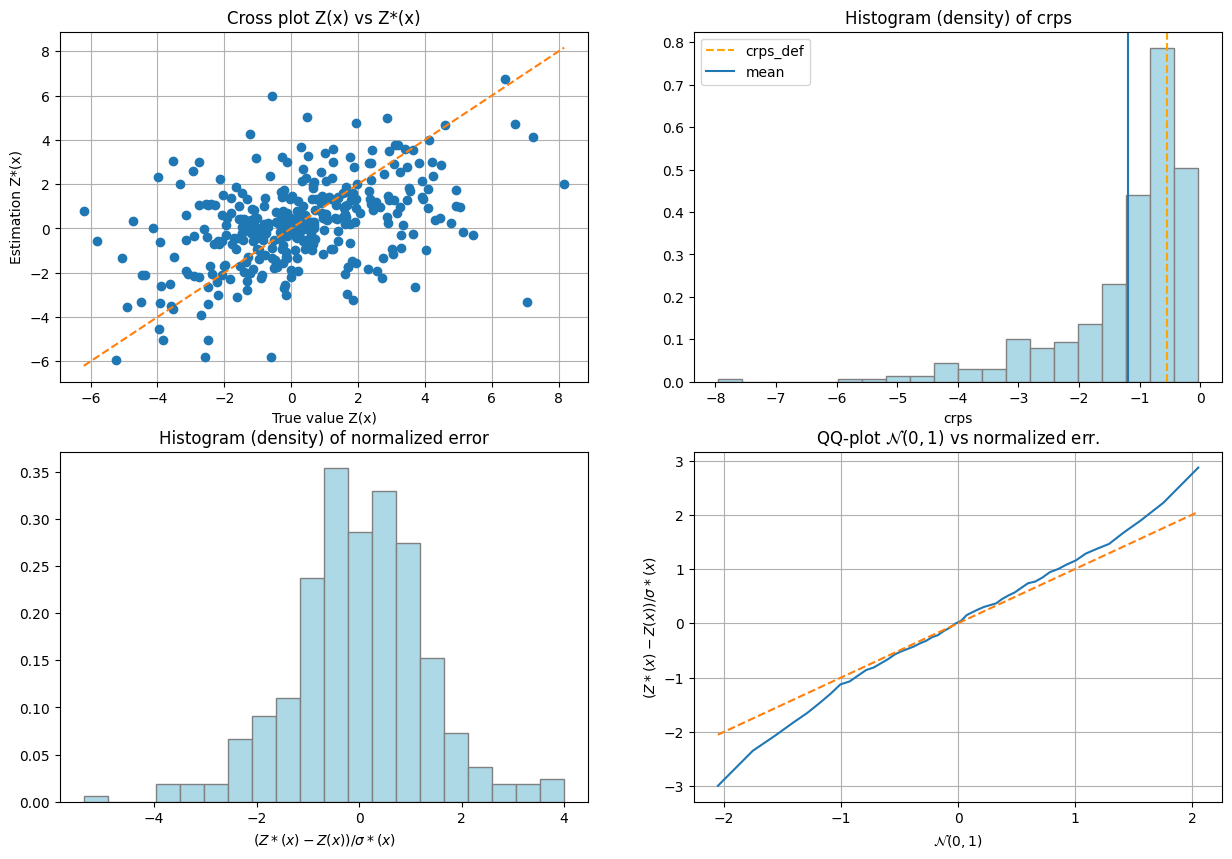

In [58]:
# Set a function interpolating the r_factor (given location)
r_factor_loc_func = gn.img.Img_interp_func(im_r_factor, ind=0, iz=0) 
# -> specify iz=0: consider only x and y coordinates in the layer iz=0

# Set a function interpolating the r_factor (given location)
w_factor_loc_func = gn.img.Img_interp_func(im_w_factor, ind=0, iz=0) 
# -> specify iz=0: consider only x and y coordinates in the layer iz=0

# Set list to handle non-stationarities at x
cov_model_non_stationarity_x_list = [
    ('multiply_r', r_factor_loc_func(x)),
    ('multiply_w', w_factor_loc_func(x))
]


# Interpolation by simple kriging
cv_est1, cv_std1, crps1, crps_def1, pvalue1, success1 = gn.covModel.cross_valid_loo(
                                        x, v, cov_model_opt,
                                        interpolator=gn.covModel.krige, 
                                        interpolator_kwargs={'method':'ordinary_kriging'},
                                        alpha_x=alpha_loc_func(x), # specify angle at data points
                                        cov_model_non_stationarity_x_list=cov_model_non_stationarity_x_list,
                                        print_result=True, make_plot=True, figsize=(15,10), nbins=20)
plt.show()

### Show experimental variogram, fitted model and reference model

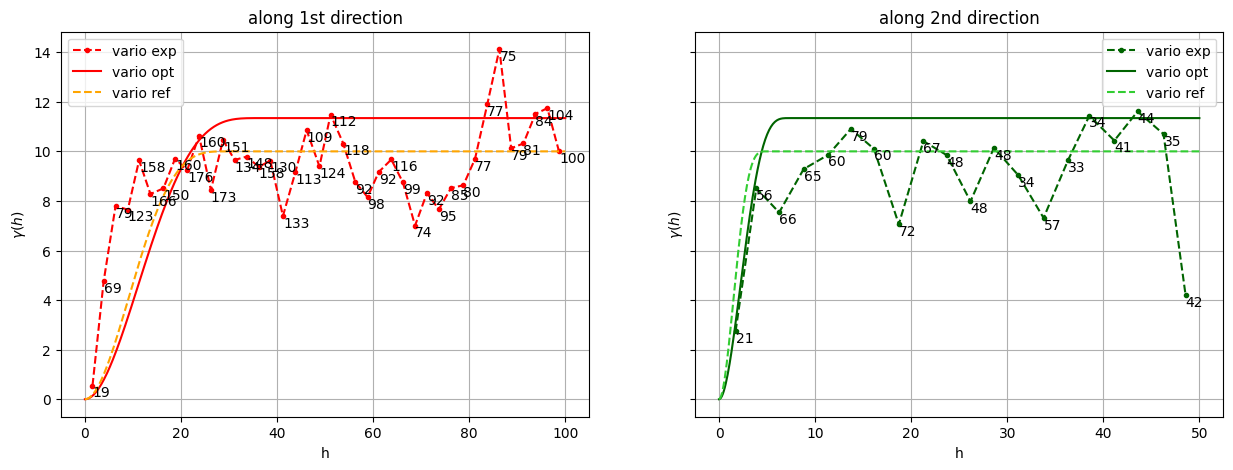

In [59]:
hmax1, hmax2 = 100.0, 50.0

(hexp1, gexp1, cexp1), (hexp2, gexp2, cexp2) = gn.covModel.variogramExp2D(
                x, v, alpha=0, hmax=(hmax1, hmax2), 
                alpha_loc_func=alpha_loc_func,
                coord1_factor_loc_func=r_factor_inv_loc_func, 
                coord2_factor_loc_func=r_factor_inv_loc_func,
                w_factor_loc_func=w_factor_inv_loc_func, 
                loc_m=1,
                ncla=(40, 20), make_plot=False)

plt.subplots(1,2, sharey=True, figsize=(15,5))
plt.subplot(1,2,1)
gn.covModel.plot_variogramExp1D(hexp1, gexp1, cexp1, c='red', label='vario exp')
cov_model_opt.plot_model_one_curve(vario=True, main_axis=1, hmax=hmax1, c='red', label='vario opt')
cov_model_base.plot_model_one_curve(vario=True, main_axis=1, hmax=hmax1, c='orange', ls='dashed', label='vario ref')
plt.legend()
plt.title("along 1st direction")

plt.subplot(1,2,2)
gn.covModel.plot_variogramExp1D(hexp2, gexp2, cexp2, c='darkgreen', label='vario exp')
cov_model_opt.plot_model_one_curve(vario=True, main_axis=2, hmax=hmax2, c='darkgreen', label='vario opt')
cov_model_base.plot_model_one_curve(vario=True, main_axis=2, hmax=hmax2, c='limegreen', ls='dashed', label='vario ref')
plt.legend()
plt.title("along 2nd direction")

plt.show()

### Kriging and conditional simulations

In [60]:
# Kriging
t1 = time.time() # start time
geosclassic_output = gn.geosclassicinterface.estimate(
                        cov_model_opt, (nx, ny), (sx, sy), (ox, oy), 
                        x=x, v=v, 
                        method='simple_kriging',
                        alpha=alpha_loc_func_xy,
                        cov_model_non_stationarity_list=cov_model_non_stationarity_list,
                        nneighborMax=20,
                        nthreads=8)
t2 = time.time() # end time
print(f'Kriging - elapsed time: {t2-t1:.4g} sec')

# Retrieve kriging estimate and standard deviation
im_krig = geosclassic_output['image']

estimate: Preprocessing data done: final number of data points : 350, inequality data points: 0
estimate: Computational resources: nthreads = 8, nproc_sgs_at_ineq = 8
estimate: (Step 1) No inequality data
estimate: (Step 2) Set new dataset gathering data and inequality data locations...
estimate: (Step 3) Do kriging at the center of grid cells containing at least one data point...
estimate: (Step 4) Do kriging on the grid (at cell centers) using data points at cell centers...
estimate: Geos-Classic running on 1 process... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 8 thread(s)]
run_MPDSOMPGeosClassicSim: Geos-Classic running... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 8 thread(s)]
run_MPDSOMPGeosClassicSim: Geos-Classic run complete
estimate: Geos-Classic (1 process) run complete
estimate: warnings encountered (1866 times in all):
#  1: WARNING 02001: a neigbhor has been dropped (solving kriging system)
#  2: WARNING 02015: solving kriging system fails (do as if no neighbor)
Kri

In [61]:
# Simulation
nreal = 50
np.random.seed(22131)
t1 = time.time() # start time
geosclassic_output = gn.geosclassicinterface.simulate(
                        cov_model_opt, (nx, ny), (sx, sy), (ox, oy), 
                        x=x, v=v, 
                        method='simple_kriging', 
                        alpha=alpha_loc_func_xy,
                        cov_model_non_stationarity_list=cov_model_non_stationarity_list,
                        nneighborMax=20,
                        nreal=nreal,
                        nproc=2, nthreads_per_proc=4)
t2 = time.time() # end time
print(f'{nreal} simul. - elapsed time: {t2-t1:.4g} sec')

# Retrieve the realizations
simul = geosclassic_output['image']

# Compute mean and standard deviation (pixel-wise)
simul_mean = gn.img.imageContStat(simul, op='mean')
simul_std = gn.img.imageContStat(simul, op='std')

simulate: Preprocessing data done: final number of data points : 350, inequality data points: 0
simulate: Computational resources: nproc = 2, nthreads_per_proc = 4, nproc_sgs_at_ineq = 8
simulate: (Step 1) No inequality data
simulate: (Step 2) Set new dataset gathering data and inequality data locations...
simulate: (Step 3) Do kriging at the center of grid cells containing at least one data point...
simulate: (Step 4) Do sgs (50 realizations) on the grid (at cell centers) using data points at cell centers...
simulate: Geos-Classic running on 2 process(es)... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 4 thread(s)]
run_MPDSOMPGeosClassicSim [pid=0]: Geos-Classic running... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 4 thread(s)]
run_MPDSOMPGeosClassicSim [pid=0]: Geos-Classic run complete
simulate: Geos-Classic (2 process(es)) run complete
simulate: warnings encountered (457 times in all):
#  1: WARNING 02001: a neigbhor has been dropped (solving kriging system)
50 simul. - elapsed

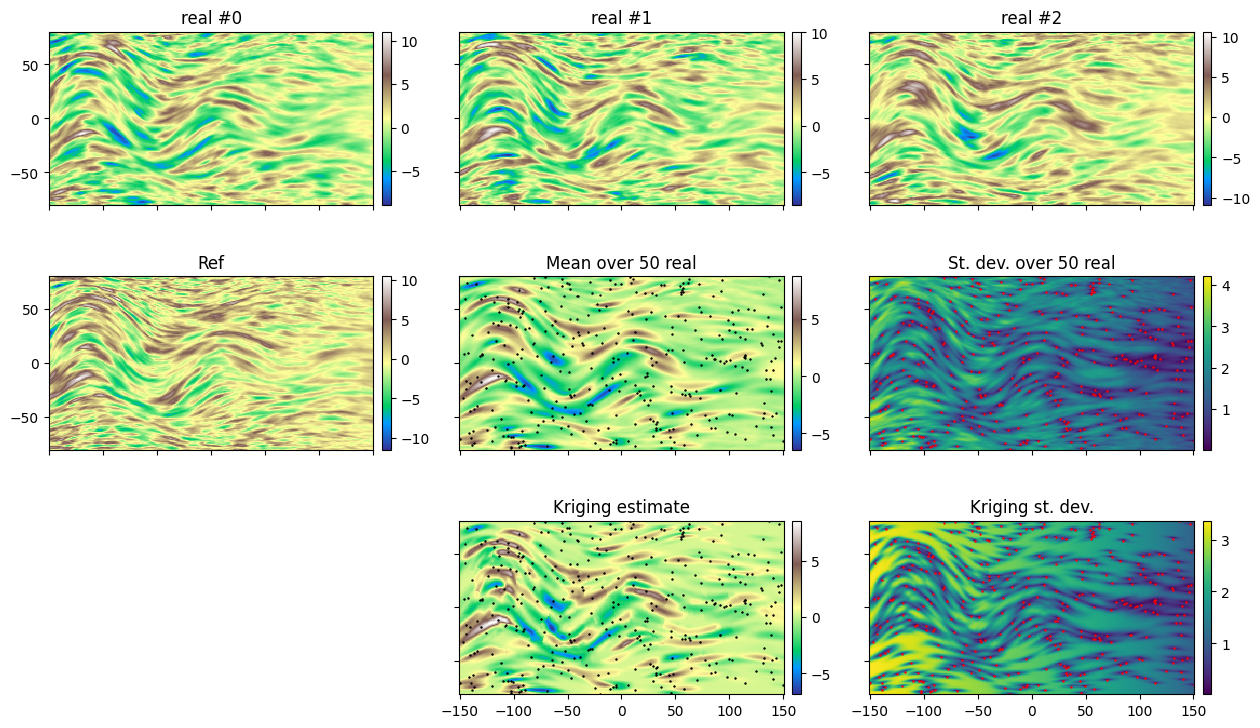

In [62]:
cmap = 'terrain'

# Plot
fig, ax = plt.subplots(3, 3, figsize=(15, 9), sharex=True, sharey=True)

# 3 first real ...
for i in (0, 1, 2):
    plt.subplot(3, 3, i+1)
    gn.imgplot.drawImage2D(simul, iv=i, cmap=cmap)
    #plt.plot(x[:,0],x[:,1], '+', c='black', markersize=10) # add conditioning point locations
    plt.title('real #{}'.format(i))

# ref 
plt.subplot(3, 3, 4)
gn.imgplot.drawImage2D(im_ref, cmap=cmap)
#plt.plot(x[:,0],x[:,1], '+', c='black', markersize=10) # add conditioning point locations
plt.title('Ref')

# mean of all real
plt.subplot(3, 3, 5)
gn.imgplot.drawImage2D(simul_mean, cmap=cmap)
plt.plot(x[:,0],x[:,1], '+', c='black', markersize=2) # add conditioning point locations
plt.title('Mean over {} real'.format(nreal))

# standard deviation of all real
plt.subplot(3, 3, 6)
gn.imgplot.drawImage2D(simul_std, cmap='viridis')
plt.plot(x[:,0],x[:,1], '+', c='red', markersize=2) # add conditioning point locations
plt.title('St. dev. over {} real'.format(nreal))

plt.subplot(3, 3, 7)
plt.axis('off')

# kriging estimate
plt.subplot(3, 3, 8)
gn.imgplot.drawImage2D(im_krig, iv=0, cmap=cmap)
plt.plot(x[:,0],x[:,1], '+', c='black', markersize=2) # add conditioning point locations
plt.title('Kriging estimate')

# kriging standard deviation
plt.subplot(3, 3, 9)
gn.imgplot.drawImage2D(im_krig, iv=1, cmap='viridis')
plt.plot(x[:,0],x[:,1], '+', c='red', markersize=2) # add conditioning point locations
plt.title('Kriging st. dev.')

plt.show()